# A. *Business Understanding*

A group of real estate agents in *King County* have recently started a company that builds custom homes. The company will primarily cater to those with a middle-class income who desire a classy, but not extravagant, home that is uniquely suited to their own tastes and lifestyle. Their main focus will be designing and constructiong homes that are affordable, and have superior equity value compared to similar homes on the market, benefitting their customers financially in the long term.  

Furthermore, the company plans to design and construct homes based off some floor plan chosen by the customer. The process begins with the proposal of an initial floor plan by the customer, from which an initial estimate for the cost of the home is calculated based on the proposed floor plan. The initial proposal is either accepted or changed in order to bring the estimated cost in the customer's budget range. Once the proposal is approved, the next step involves maximizing the equity of the new home by making adjustments to the floor plan and recommending the best locations to look for a lot (if a lot has not been purchased by the customer yet). Once this second proposal is approved, the proposal stage is finished and the process moves on to drawing schematics from this floor plan.

However, the company lacks a robust way of accurately estimating and predicting the value of a home in *King County*. This renders them unable to compare the projected costs of their custom floor plans to similar houses on the market in *King County*, which means they can't actually gauge how affordable their homes will be with respect to other homes currently for sale in the county. Similarly, they have no way of estimating what the equity of one of their homes will be upon completion.

> They require that a model be constructed that can accurately estimate the market value of a home in *King County*. Aditionally, the company specifies that the following types of parameters be included in the model:
> * _physical attributes of the home_ 
> * _the location of the home/characteristics of the surrounding area_
> * _any other attributes that may be linked to a home's equity_

# B. *Data Understanding*

## B.1 - Overview of the Dataset

> __The data comprises of a single dataset describing home sales in _King County, Washington_ from May 2014 to May 2015.__

A description of each column in the dataset is listed below:

> * __id__ - _unique identifier for each home sold_
> * __date__ - _date of sale_
> * __price__ - _price at which home was sold_
> * __bedrooms__ - _number of bedrooms_
> * __bathrooms__ - _number of bathrooms, where:_
>    - *0.5 = half bath (sink + toilet)* 
>    - *0.75 = three-quarter bath (sink + toilet + shower)*
>    - *1 = full bath (sink + toilet + shower + tub)*
> * __sqft_living__ - *square footage of the interior living space*
> * __sqft_lot__ - *square footage of the lot*
> * __floors__ - *number of floors*
> * __waterfront__ - *binary column indicating whether or not the home is a waterfront property*
> * __view__ - *index measuring how good the view is from the property [0 - 4]*
> * __condition__ - *index measuring the condition of the apartment [1 - 5]*
> * __grade__ - *index measuring quality of building construction and design [1 - 13]*
> * __sqft_above__ - *square footage of the interior living space other than the basement*
> * __sqft_basement__ - *square footage of the basement*
> * __yr_built__ - *year in which home was initially built*
> * __yr_renovated__ - *year of the most recent renovation*
> * __zipcode__ - *zipcode house is located in*
> * __lat__ - *latitude*
> * __long__ - *longitude*
> * __sqft_living15__ - The square footage of interior housing living space for the nearest 15 neighbors
> * __sqft_lot15__ - The square footage of the land lots of the nearest 15 neighbors

From the descriptions above, we can split the predictor variables into three categories:
* __Numerical (Continuous)__ -  ```sqft_living, sqft_above, sqft_basement, sqft_lot, sqft_living15, sqft_lot15, lat, long, yr_renovated, yr_built```
* __Numerical (Discrete)__ - ```bedrooms, bathrooms, floors, view, condition, grade```
* __Categorical__ - ```is_waterfront```

## B.2 - Importing the *King County* Housing Dataset

In [134]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("notebook")


The dataset resides in the `kc_house_data.csv` file located in the `data` directory of this project. The `id` column is set as the DataFrame index because it helps ensure proper alignment of the dataset. The `date` and `view` columns will be dropped because they are irrelevant to the business problem.

In [135]:
from regression_utils import RegressionDataWrapper, ols_regression, plot_residuals

data = pd.read_csv("data/kc_house_data.csv").rename(columns={"waterfront": "is_waterfront"}).set_index("id")
data["is_waterfront"] = data["is_waterfront"].map(lambda x: int(bool(x)))
data = RegressionDataWrapper(data, target="price", discrete_vars=["bedrooms", "bathrooms", "floors",  "condition", "grade"], categorical_vars=["is_waterfront"], drop_cols=["view", "date", "zipcode", "lat", "long"])

## B.3 - Viewing the Main Attributes of the Dataset

From the summary below highlights two problems that will need to be addressed during data preparation: 
> * *the entries in the `sqft_basement` are strings*
> * *the `is_waterfront` and `yr_renovated` columns contain null values*

In [136]:
data.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 7129300520 to 1523300157
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   is_waterfront  21597 non-null  int64  
 7   condition      21597 non-null  int64  
 8   grade          21597 non-null  int64  
 9   sqft_above     21597 non-null  int64  
 10  sqft_basement  21597 non-null  object 
 11  yr_built       21597 non-null  int64  
 12  yr_renovated   17755 non-null  float64
 13  sqft_living15  21597 non-null  int64  
 14  sqft_lot15     21597 non-null  int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 2.6+ MB


## B.4 - Inspecting the Distribution of the Target (`price`)

From the distributions of the target, it can be seen that:

* _```price``` is heavily right-skewed_ 

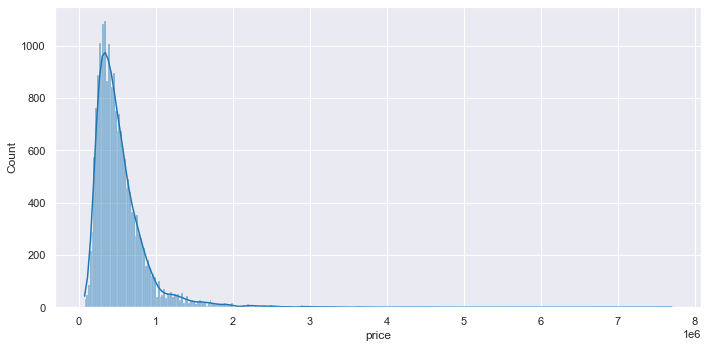

In [137]:
data.plot_distribution(data.target)

## B.5 - Inspecting the Distributions of the Predictors

### B.5.1 - Numerical Predictors (Continuous)

From the distributions of the continuous predictors, it can be seen that:

* _```sqft_living, sqft_above, sqft_living15``` are moderately right-skewed_ 
* _```sqft_lot, sqft_lot15``` are extremely right-skewed_ 
* _the vast majority of values for ```yr_renovated, sqft_basement``` seem to be zero_

In [138]:
continuous_predictors = data.cont_predictors
# data.plot_distribution(continuous_predictors)

### B.5.2 - Numerical Predictors (Discrete)

From the distributions of the discrete predictors, it can be seen that:

* _`bedrooms` is right-skewed, with the majority of homes having between $2$ and $5$ bedrooms_
* _`bathrooms` is right-skewed, with the majority of homes having between $2$ and $4$ bathrooms_
* _`condition` is left-skewed, with the vast majority of homes having a rating of $3$ and above_

In [139]:
discrete_predictors = data.disc_predictors
# data.plot_distribution(discrete_predictors)

### B.5.3 - Categorical Predictors

In [140]:
# data.plot_distribution(is_waterfront)

# C. *Data Preparation*

## C.1 - Handling String Values

The list below, showing the data type of each column in the dataset, indicates that the `sqft_basement` column contains strings instead of numeric values.

In [141]:
data.df.dtypes

price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
is_waterfront      int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement     object
yr_built           int64
yr_renovated     float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

The cell outputs below indicate that $453$ of the entries in `sqft_basement` are simply a '`?`' character. It is unclear how this value should be interpreted because it is difficult to imagine how confusion could arise around something as straightforward as the size of the basement. Nevertheless, it will be assumed that these homes do not have a basement, and their values for `sqft_basement` will correspondingly be set to `0`.  

In [142]:
data.df["sqft_basement"].str.split('.').map(lambda x: all(str.isdigit(n) for n in x)).value_counts()

True     21144
False      453
Name: sqft_basement, dtype: int64

In [143]:
data.df["sqft_basement"].map(lambda x: x[0]).unique()

array(['0', '4', '9', '1', '?', '7', '3', '8', '5', '6', '2'],
      dtype=object)

In [144]:
data.df["sqft_basement"] = data.df["sqft_basement"].str.replace('?', '0.0').astype('float64')

<ipython-input-144-8a8149754f0f>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  data.df["sqft_basement"] = data.df["sqft_basement"].str.replace('?', '0.0').astype('float64')


We can confirm that `sqft_basement` is now a numerical column.

In [145]:
data.df["sqft_basement"].dtype

dtype('float64')

## C.2 - Handling Null Values (`NaN`) 

The summary below shows that the `yr_renovated` and `is_waterfront` columns contain null values.

In [146]:
data.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 7129300520 to 1523300157
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   is_waterfront  21597 non-null  int64  
 7   condition      21597 non-null  int64  
 8   grade          21597 non-null  int64  
 9   sqft_above     21597 non-null  int64  
 10  sqft_basement  21597 non-null  float64
 11  yr_built       21597 non-null  int64  
 12  yr_renovated   17755 non-null  float64
 13  sqft_living15  21597 non-null  int64  
 14  sqft_lot15     21597 non-null  int64  
dtypes: float64(5), int64(10)
memory usage: 2.6 MB


### C.2.1 - Replacing Null Values in `yr_renovated` Column

For data in the `yr_renovated` column, a null value is assumed to indicate that the house has never been renovated, and will be replaced with the integer `0`.

In [147]:
data.df["yr_renovated"].fillna(0, inplace=True)

In [148]:
all(data.df["yr_renovated"].notna())

True

### C.2.2 - Replacing Null Values in `is_waterfront` Column

Similar to the `yr_renovated` column, a null value in the `is_waterfront` column is assumed to indicate that the house is not a waterfront property, and will be replaced with the integer `0`.

In [149]:
data.df["is_waterfront"].fillna(0, inplace=True)

In [150]:
all(data.df["is_waterfront"].notna())

True

## C.3 - Dealing with Homes that Appear More than Once in the Dataset

There are duplicate values in the `id` column because some properties in the dataset were listed on more than one occassion. As can be seen in the output below, these data rows are nearly identical, except they differ in their values of `price`. 

In [151]:
data.df.index.has_duplicates

True

In [152]:
duplicates_df = data.df.loc[data.df.index.value_counts().map(lambda x: x > 1)].sort_index()
duplicates_df.head(6)

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
id                                                                        
1000102    300000.0         6       3.00         2400      9373     2.0   
1000102    280000.0         6       3.00         2400      9373     2.0   
7200179    150000.0         2       1.00          840     12750     1.0   
7200179    175000.0         2       1.00          840     12750     1.0   
109200390  250000.0         3       1.75         1480      3900     1.0   
109200390  245000.0         3       1.75         1480      3900     1.0   

           is_waterfront  condition  grade  sqft_above  sqft_basement  \
id                                                                      
1000102                0          3      7        2400            0.0   
1000102                1          3      7        2400            0.0   
7200179                0          3      6         840            0.0   
7200179                0          3      6         840            0.0   
109200390              0          4      7        1480            0.0   
109200390              0          4      7        1480            0.0   

           yr_built  yr_renovated  sqft_living15  sqft_lot15  
id                                                            
1000102        1991           0.0           2060        7316  
1000102        1991           0.0           2060        7316  
7200179        1925           0.0           1480        6969  
7200179        1925           0.0           1480        6969  
109200390      1980           0.0           1830        6956  
109200390      1980           0.0           1830        6956

The cells above indicate that seasonality may affect a home's seling price, but the business problem puts emphasis on investigating the physical and location-related attributes of a home. Thus, these records will be resolved into a single row by taking their average `price` value.

In [153]:
duplicate_average_prices = duplicates_df.groupby("id").price.mean()
duplicates_df = pd.concat([duplicate_average_prices, duplicates_df.loc[:, "bedrooms": "sqft_lot15"]], axis=1).drop_duplicates()
duplicates_df.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
id                                                                        
1000102    290000.0         6       3.00         2400      9373     2.0   
1000102    290000.0         6       3.00         2400      9373     2.0   
7200179    162500.0         2       1.00          840     12750     1.0   
109200390  247500.0         3       1.75         1480      3900     1.0   
123039336  196450.0         1       1.00          620      8261     1.0   

           is_waterfront  condition  grade  sqft_above  sqft_basement  \
id                                                                      
1000102                0          3      7        2400            0.0   
1000102                1          3      7        2400            0.0   
7200179                0          3      6         840            0.0   
109200390              0          4      7        1480            0.0   
123039336              0          3      5         620            0.0   

           yr_built  yr_renovated  sqft_living15  sqft_lot15  
id                                                            
1000102        1991           0.0           2060        7316  
1000102        1991           0.0           2060        7316  
7200179        1925           0.0           1480        6969  
109200390      1980           0.0           1830        6956  
123039336      1939           0.0           1180        8244

In [154]:
duplicates_df.index.has_duplicates

True

In [155]:
duplicate_indices = duplicates_df.index.unique()
duplicate_indices

Int64Index([   1000102,    7200179,  109200390,  123039336,  251300110,
             302000375,  324000530,  526059224,  641900050,  643300040,
            ...
            9211500620, 9222400605, 9238500040, 9250900104, 9353300600,
            9407110710, 9809000020, 9828200460, 9834200305, 9834200885],
           dtype='int64', name='id', length=176)

In [156]:
data.corr_with_target("bedrooms")
data.df = data.df.append(duplicates_df)
data.df.index.has_duplicates

True

## C.4 - Identifying Multicollinearity

### C.4.1 - Investigating Predictors Related to Property Size 

It is likely that, for a given property, one or more of the predictors describing the square footages (`sqft_living`, `sqft_above`, and `sqft_basement`) is correlated to one or more of the predictors describing: the number of bedrooms (`bedrooms`), number of bathrooms per bedroom (`bathrooms`), and the number of floors (`floors`). It is also reasonable to assume that the square footages may be related to eachother somehow. Therefore, it is important to check if any of the predictors are multicollinear.

In [157]:
size_predictors = ["sqft_living", "sqft_above", "sqft_basement", "bedrooms", "bathrooms", "floors"]

In [158]:
data.df[size_predictors].head()

sqft_living  sqft_above  sqft_basement  bedrooms  bathrooms  \
id                                                                        
7129300520         1180        1180            0.0         3       1.00   
6414100192         2570        2170          400.0         3       2.25   
5631500400          770         770            0.0         2       1.00   
2487200875         1960        1050          910.0         4       3.00   
1954400510         1680        1680            0.0         3       2.00   

            floors  
id                  
7129300520     1.0  
6414100192     2.0  
5631500400     1.0  
2487200875     1.0  
1954400510     1.0

Since we have:

* _**sqft_above** defined as the square footage of house apart from basement_
* _**sqft_basement** defined as the square footage of the basement_
* _**sqft_living** defined as the square footage of the home_

it stands to reason that:

> $\text{sqft\_living} = \text{sqft\_above} + \text{sqft\_basement}$

We can confirm this by inspecting the Variance Inflation Factors of the variables in `X_size`.

In [159]:
data.get_VIF_dict(size_predictors)

{'sqft_living': 146.69,
 'sqft_above': 119.02,
 'sqft_basement': 33.45,
 'const': 20.06,
 'bathrooms': 2.87,
 'floors': 1.76,
 'bedrooms': 1.59}

> _As expected, `sqft_living`, `sqft_above`, and `sqft_basement` have Variance Inflation Factors well above $10$, confirming that one of them is redundant and should be dropped._

In [160]:
data.remove_feature("sqft_above")
size_predictors.remove("sqft_above")

The Variance Inflation Factors indicate that Multicollinearity is far less likely among these predictors.

In [161]:
data.get_VIF_dict(size_predictors)

{'const': 20.05,
 'sqft_living': 3.0,
 'bathrooms': 2.87,
 'floors': 1.74,
 'sqft_basement': 1.59,
 'bedrooms': 1.59}

### C.4.2 - Investigating Predictors with High Pairwise Correlation

In [162]:
pairwise_corrs = data.get_pairwise_corrs(data.predictors, tol=0.7)
pairwise_corrs

correlation
pairs                                    
(sqft_living, grade)             0.763185
(sqft_living, sqft_living15)     0.756634
(sqft_living, bathrooms)         0.756054
(sqft_lot, sqft_lot15)           0.718977
(grade, sqft_living15)           0.714594

In [163]:
from itertools import chain
corr_vars = pd.Index(set(chain(*pairwise_corrs.index)))
corr_vars

Index(['grade', 'bathrooms', 'sqft_lot15', 'sqft_living15', 'sqft_lot',
       'sqft_living'],
      dtype='object')

In [164]:
data.get_VIF_dict(corr_vars)

{'const': 61.49,
 'sqft_living': 4.12,
 'grade': 2.82,
 'sqft_living15': 2.65,
 'bathrooms': 2.47,
 'sqft_lot15': 2.1,
 'sqft_lot': 2.08}

## C.5 - Dropping Predictors that are Uncorrelated to the Target

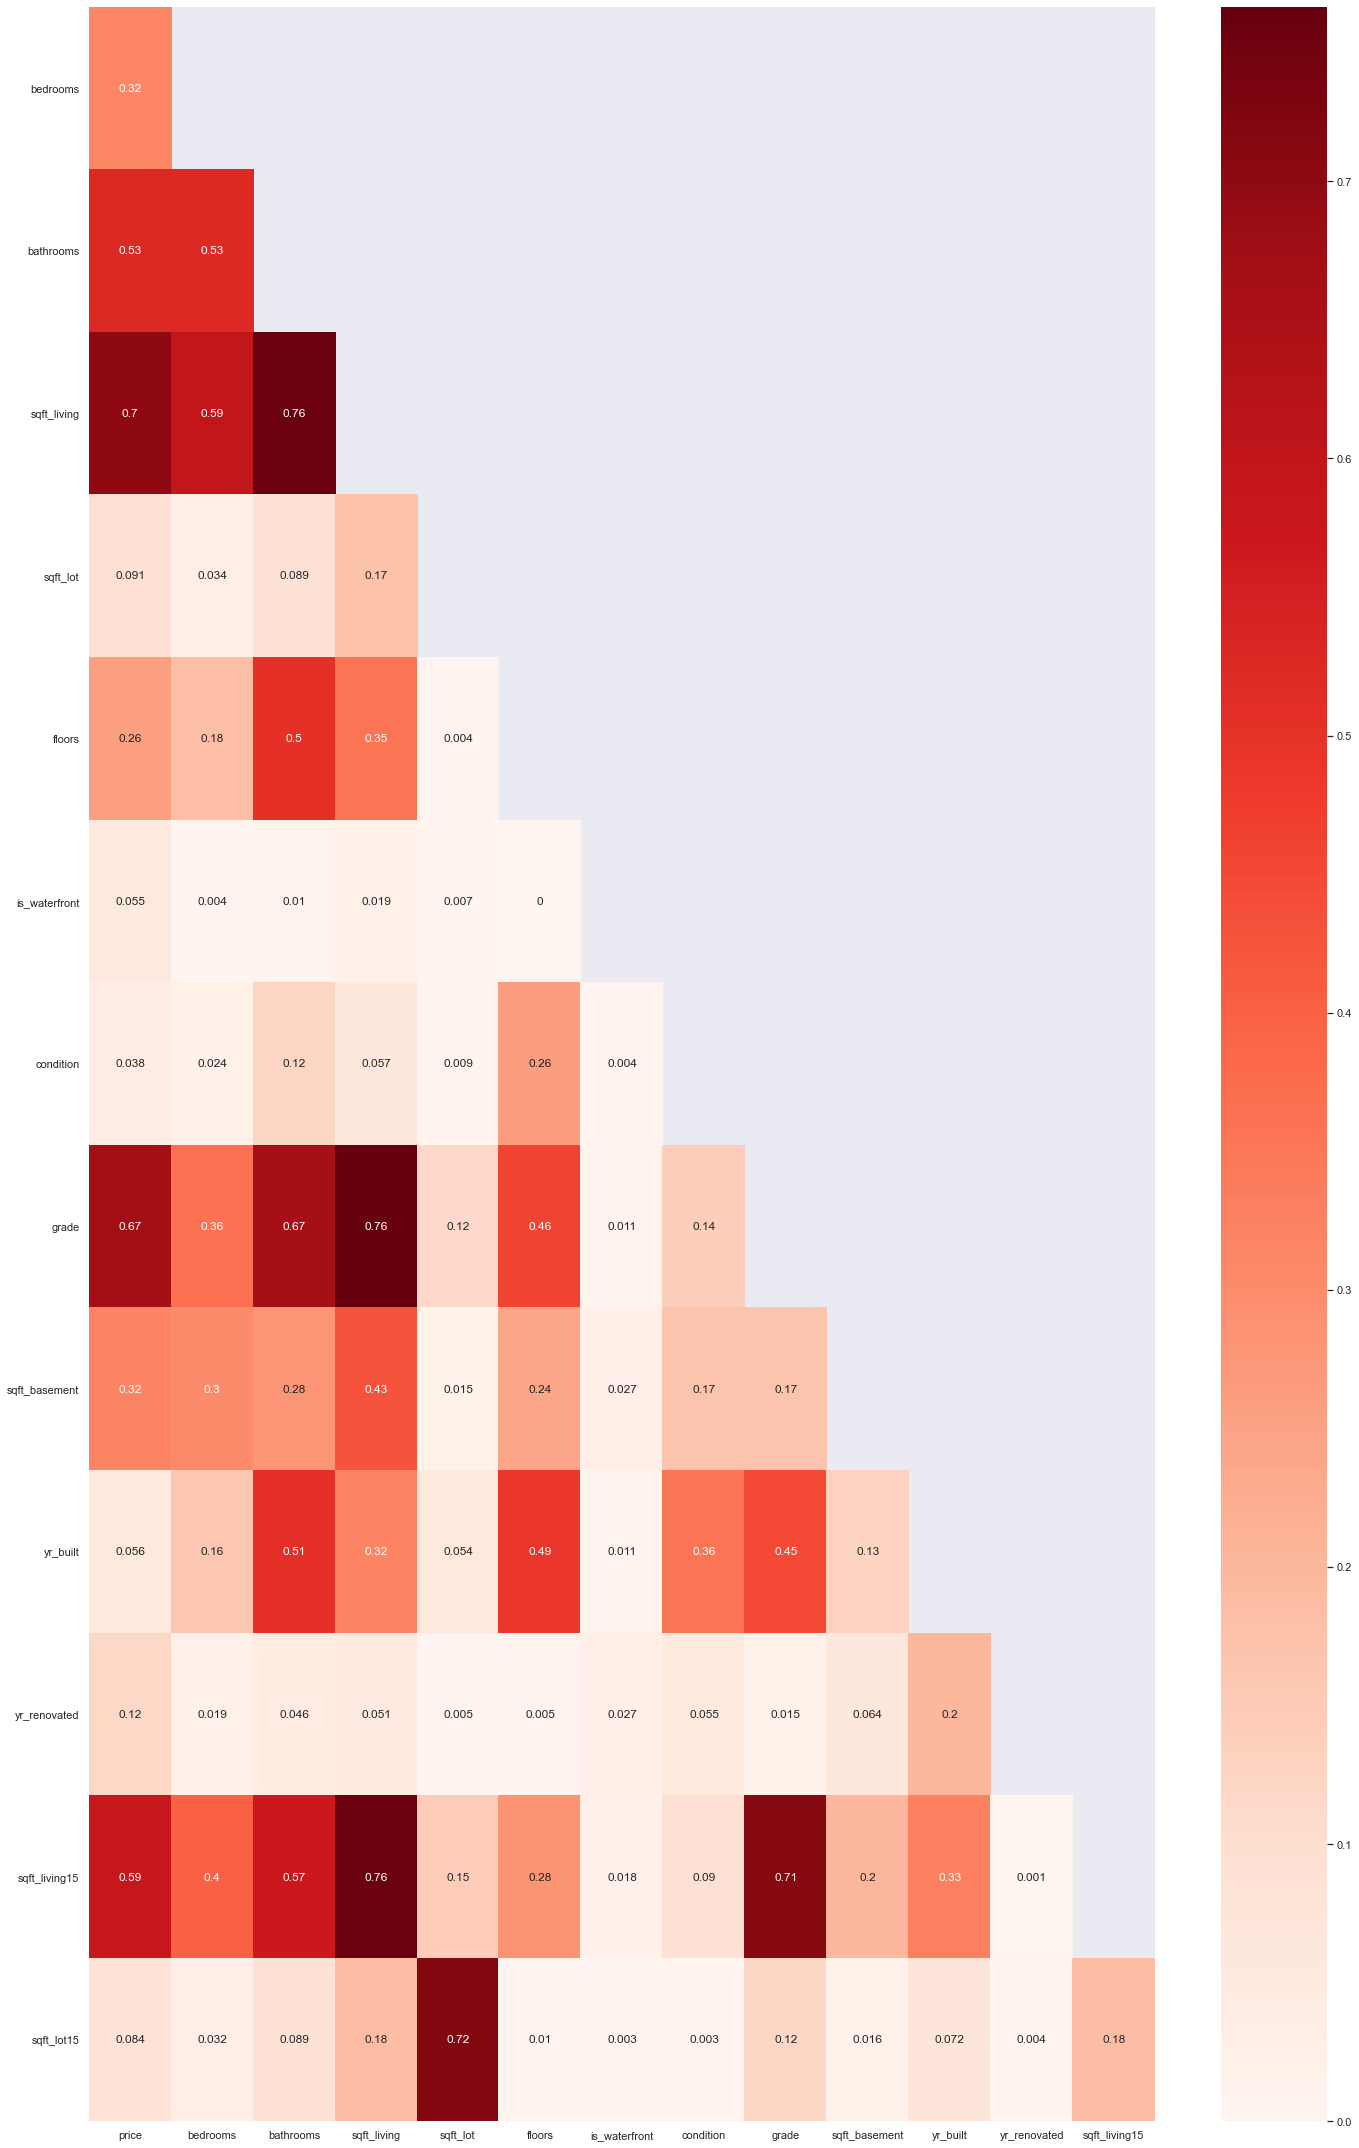

In [165]:
data.plot_corr_heatmap()

> *The heatmap sabove shows that `sqft_lot`, `sqft_lot15`, and `yr_built` have virtually no correlation with `price`, and so these variables will be dropped.*

In [166]:
for name in ["sqft_lot", "sqft_lot15", "yr_built"]:
    data.remove_feature(name)

## C.6 - Variable Processing & Feature Engineering

### __*`sqft_living`*__

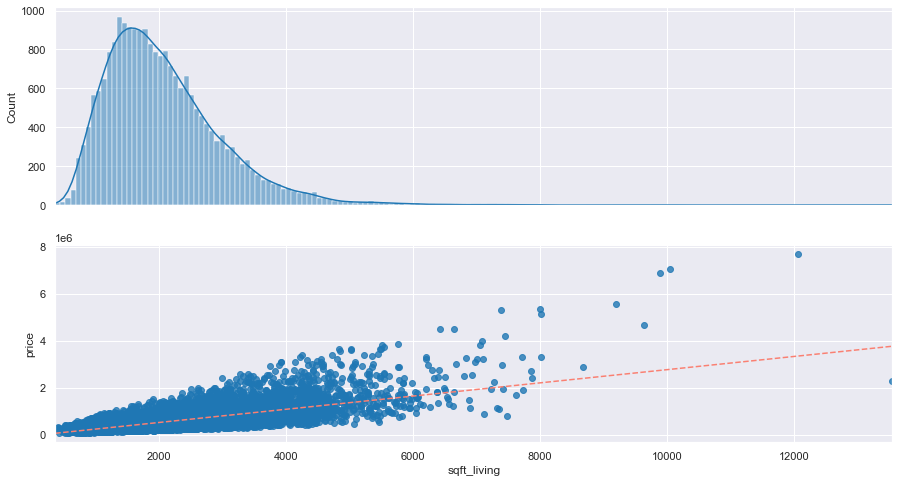

In [167]:
data.plot_predictor("sqft_living")

In [168]:
data.corr_with_target("sqft_living")

0.7024750571870607

In [169]:
data.log_transform("sqft_living")

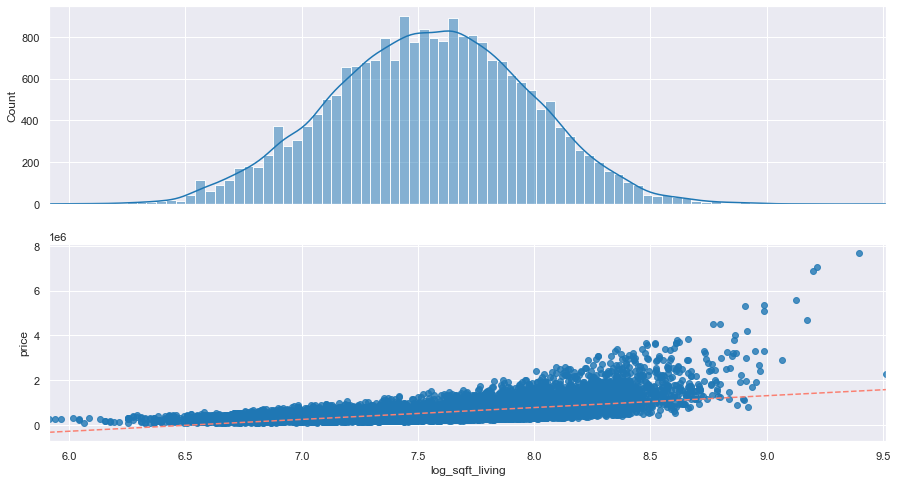

In [170]:
data.plot_predictor("log_sqft_living")

### *__`grade`__*

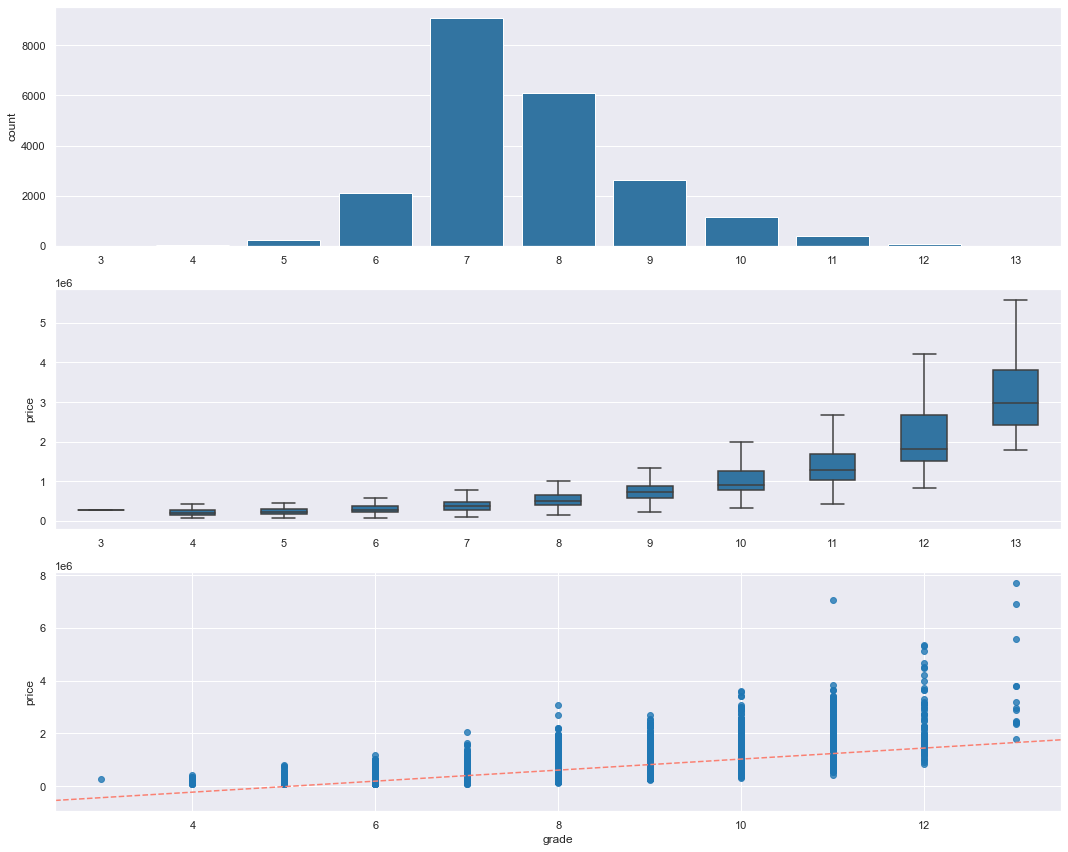

In [171]:
data.plot_predictor("grade")

In [172]:
data.corr_with_target("grade")

0.6686830370515171

### __*`sqft_living15`*__

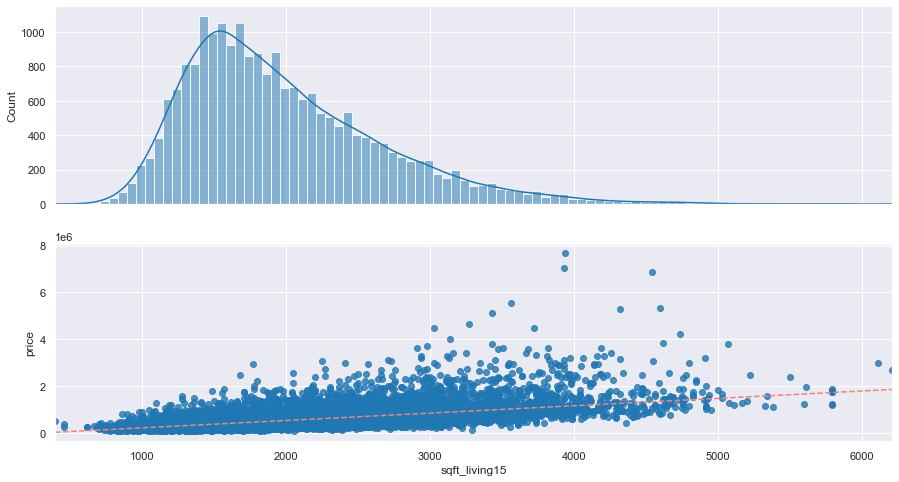

In [173]:
data.plot_predictor("sqft_living15")

In [174]:
data.corr_with_target("sqft_living15")

0.5864801617215959

In [175]:
data.log_transform("sqft_living15")

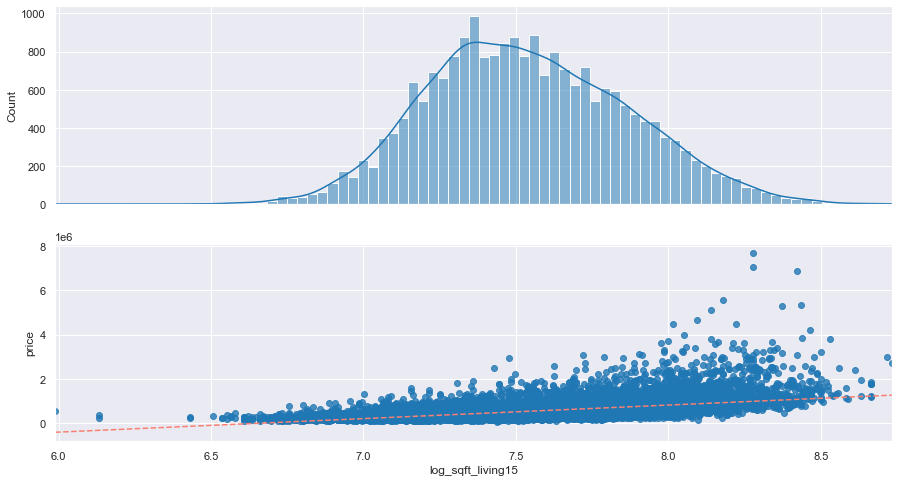

In [176]:
data.plot_predictor("log_sqft_living15")

### *__`bathrooms`__*

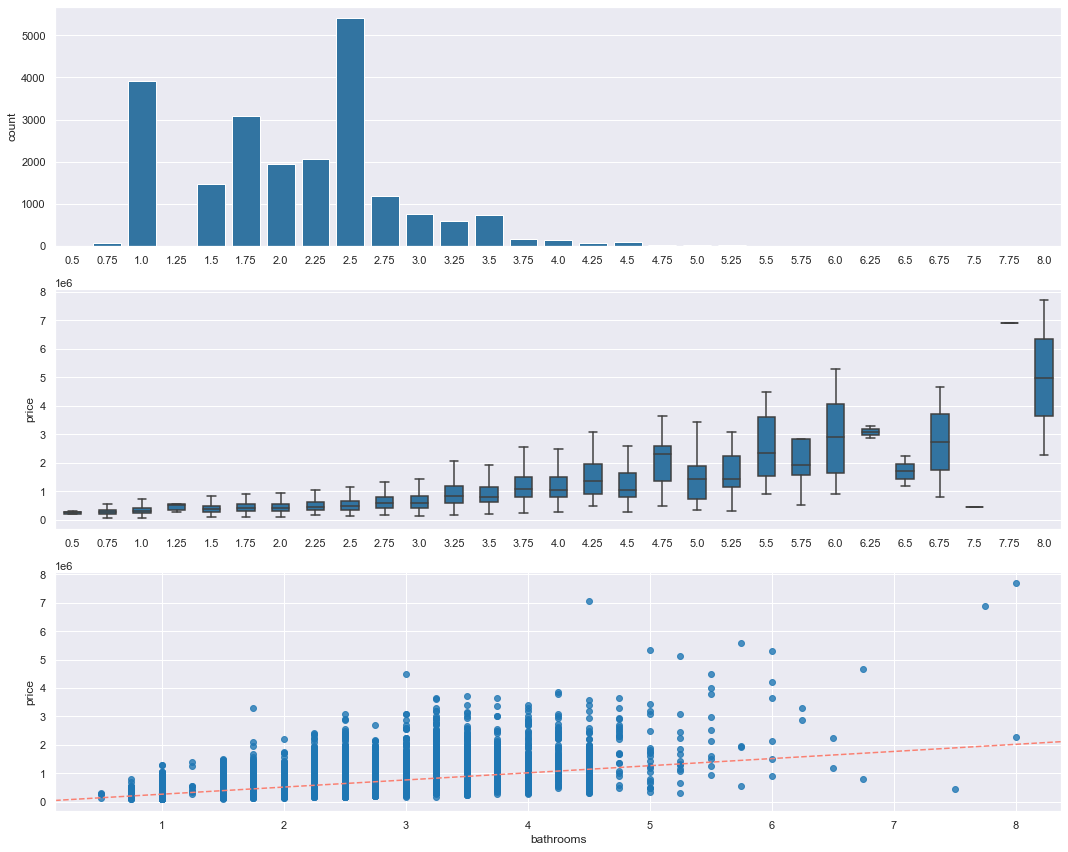

In [177]:
data.plot_predictor("bathrooms")

In [178]:
data.corr_with_target("bathrooms")

0.5262535649731048

In [179]:
data.df = data.df[data.df.bathrooms <= 6]

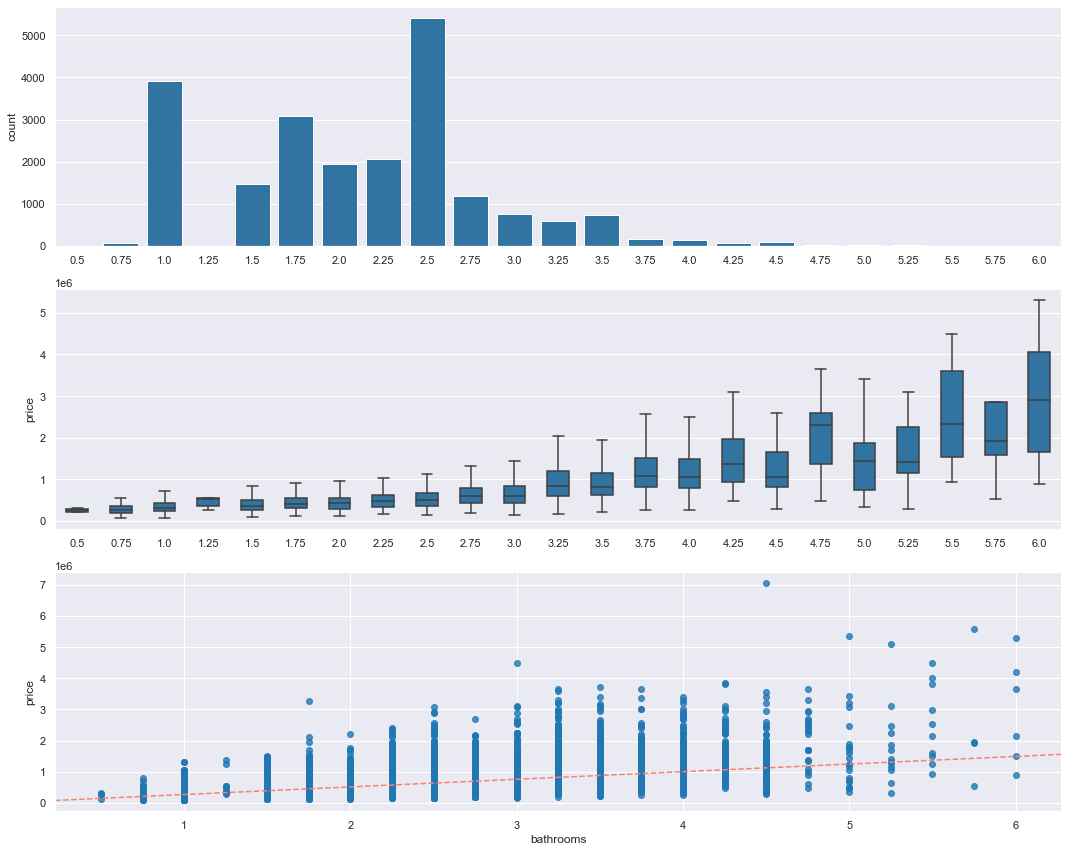

In [180]:
data.plot_predictor("bathrooms")

### __*`condition`*__

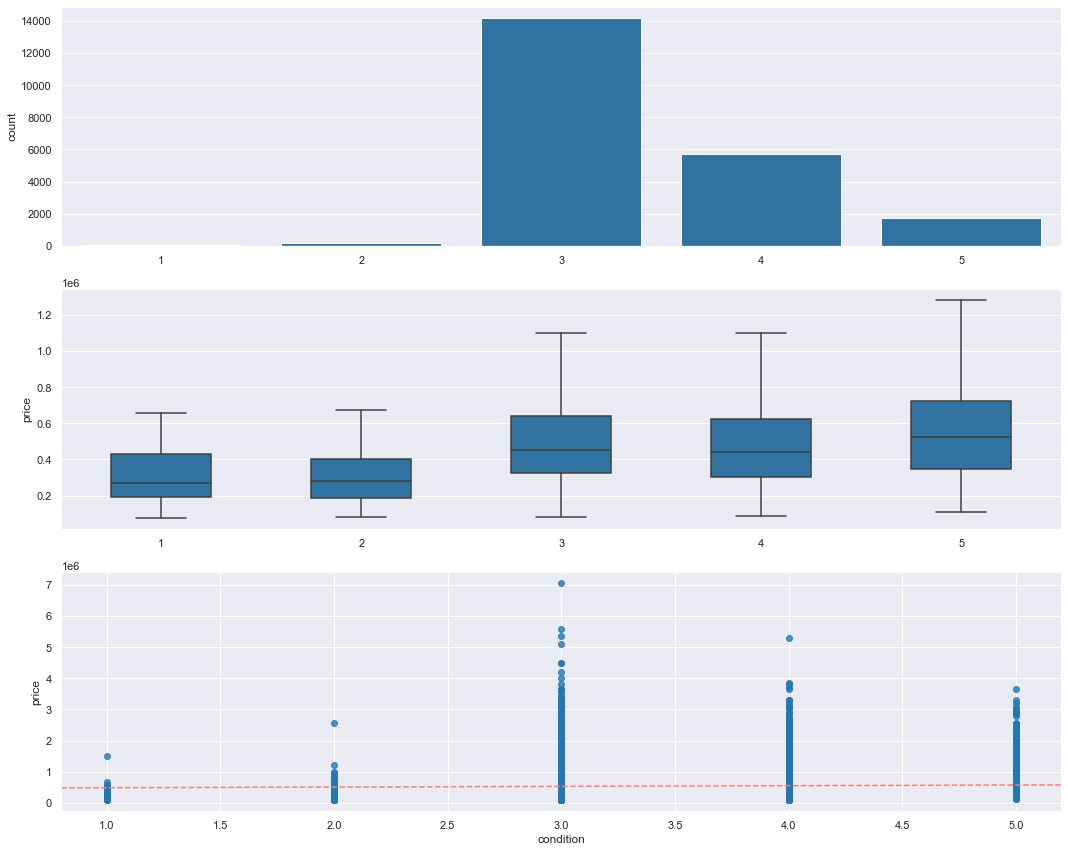

In [181]:
data.plot_predictor("condition")

In [182]:
data.corr_with_target("condition")

0.03949774923576422

### *__`sqft_basement`__*

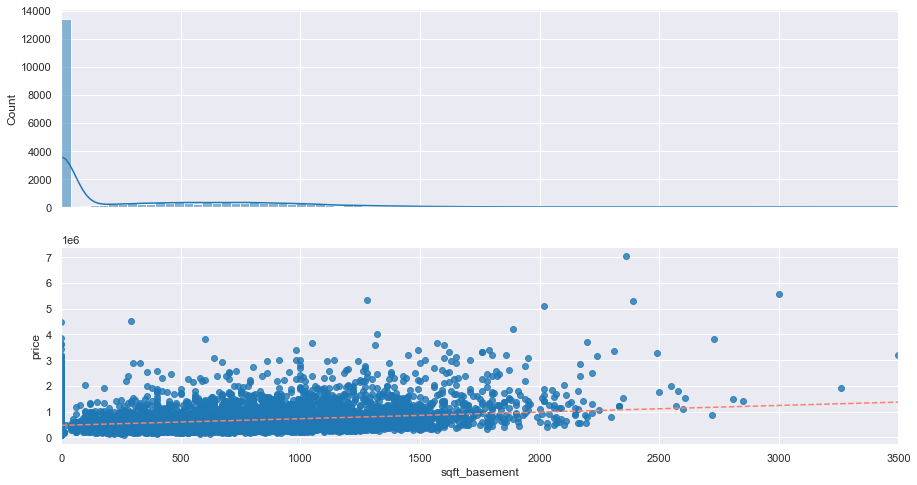

In [183]:
data.corr_with_target("sqft_basement")
data.plot_predictor("sqft_basement")

#### _Feature Engineering:_ Converting `sqft_basement` to a Categorical Variable (`has_basement`)

In [184]:
basement = data.df["sqft_basement"].map(lambda x: int(bool(x)))
data.add_feature(basement, name="has_basement", var_type="categorical")
data.remove_feature(name="sqft_basement")

In [185]:
data.X_cat.head()

has_basement  is_waterfront
id                                     
7129300520             0              1
6414100192             1              0
5631500400             0              0
2487200875             1              0
1954400510             0              0

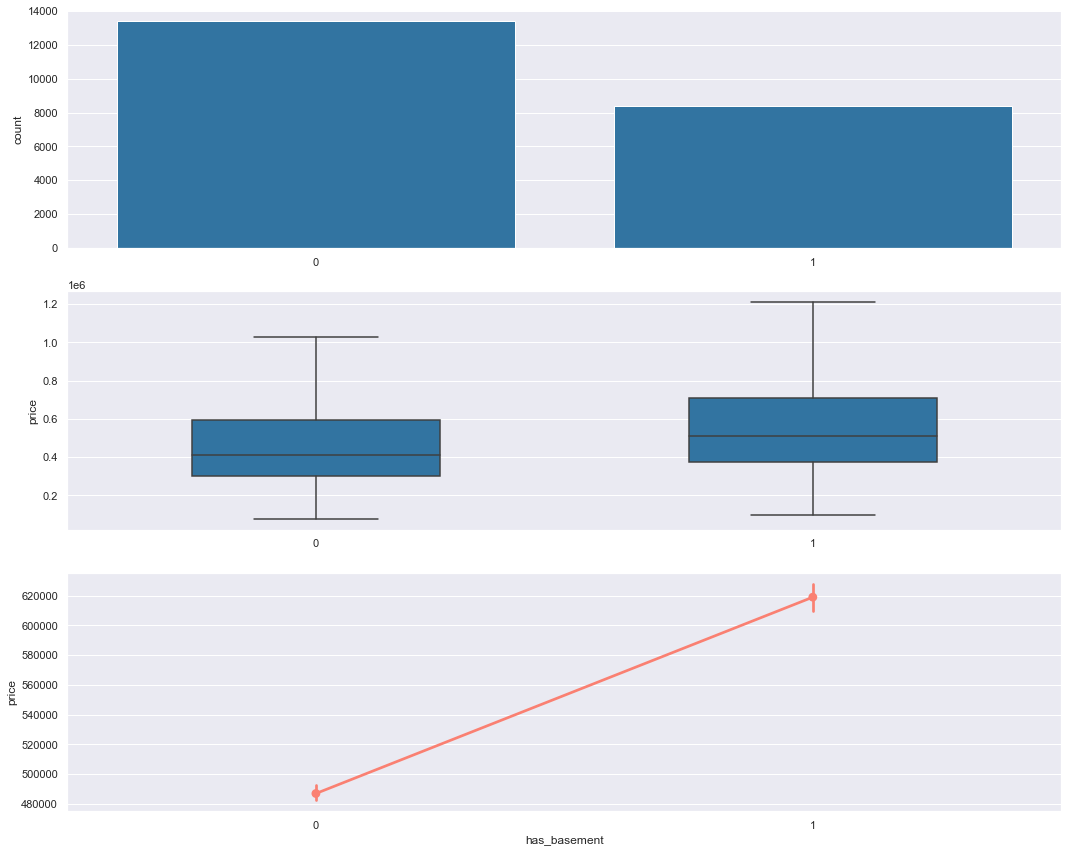

In [186]:
data.plot_predictor("has_basement")

### __`yr_renovated`__

In [187]:
data.corr_with_target("yr_renovated")


0.11259280373721386

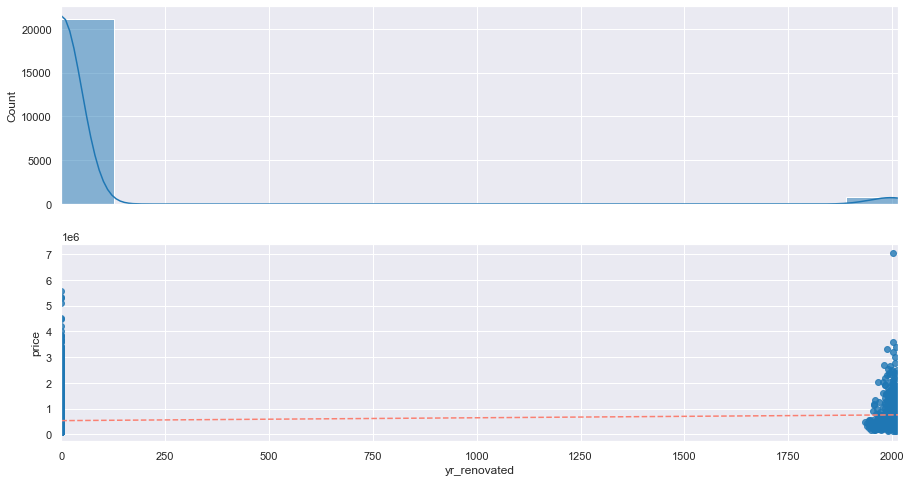

In [188]:
data.plot_predictor("yr_renovated")

#### _Feature Engineering:_ Converting `yr_renovated` to a Categorical Variable (`is_renovated`)

In [189]:
renovated = data.X["yr_renovated"].map(lambda x: int(bool(x)))
data.add_feature(renovated, name="is_renovated", var_type="categorical")
data.remove_feature(name="yr_renovated")

In [190]:
data.X_cat.head()

is_renovated  has_basement  is_waterfront
id                                                   
7129300520             0             0              1
6414100192             1             1              0
5631500400             0             0              0
2487200875             0             1              0
1954400510             0             0              0

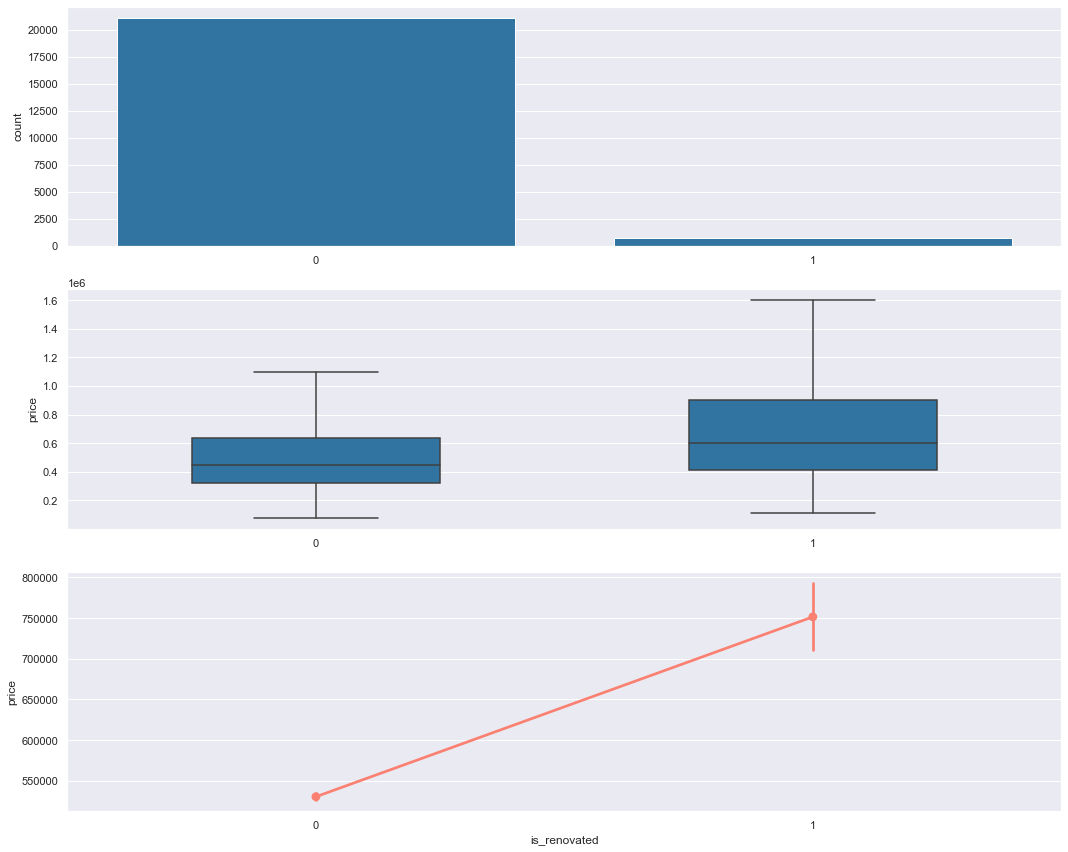

In [191]:
data.plot_predictor("is_renovated")

### __*`bedrooms`*__

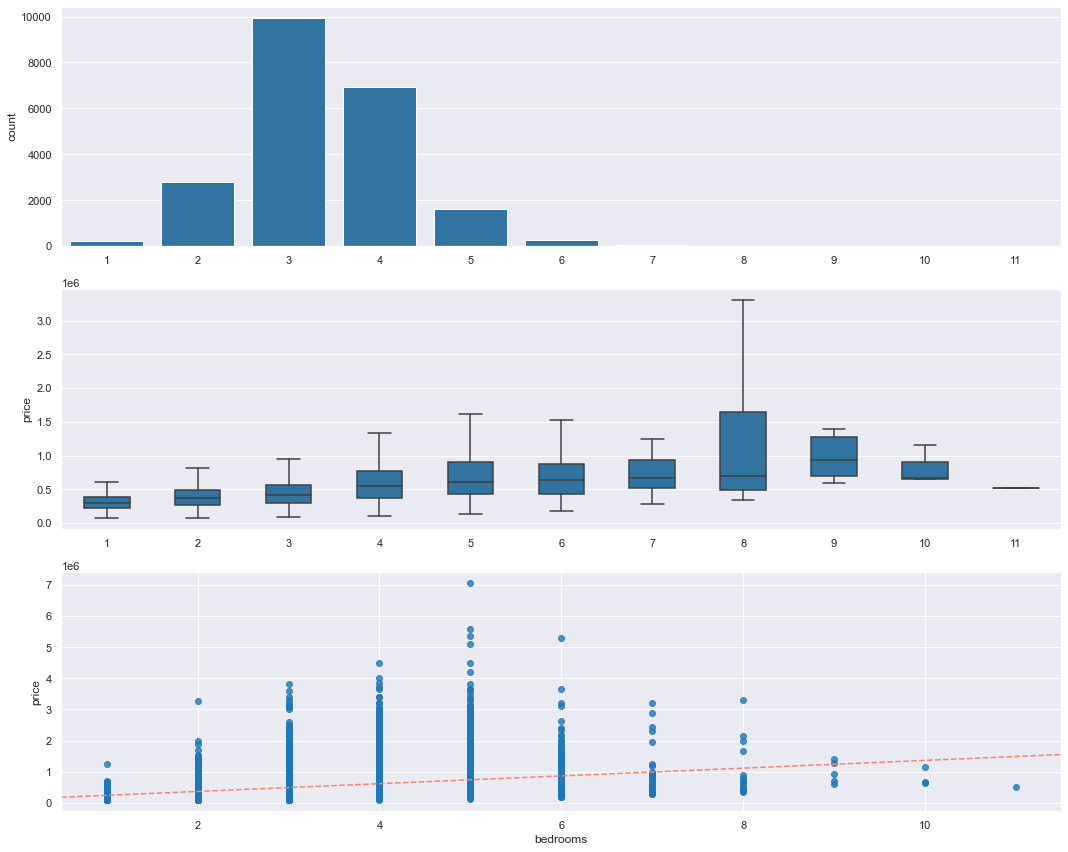

In [192]:
data.plot_predictor("bedrooms")

In [193]:
data.corr_with_target("bedrooms")

0.31388505984714443

In [194]:
data.df = data.df.loc[data.df.bedrooms <= 9]

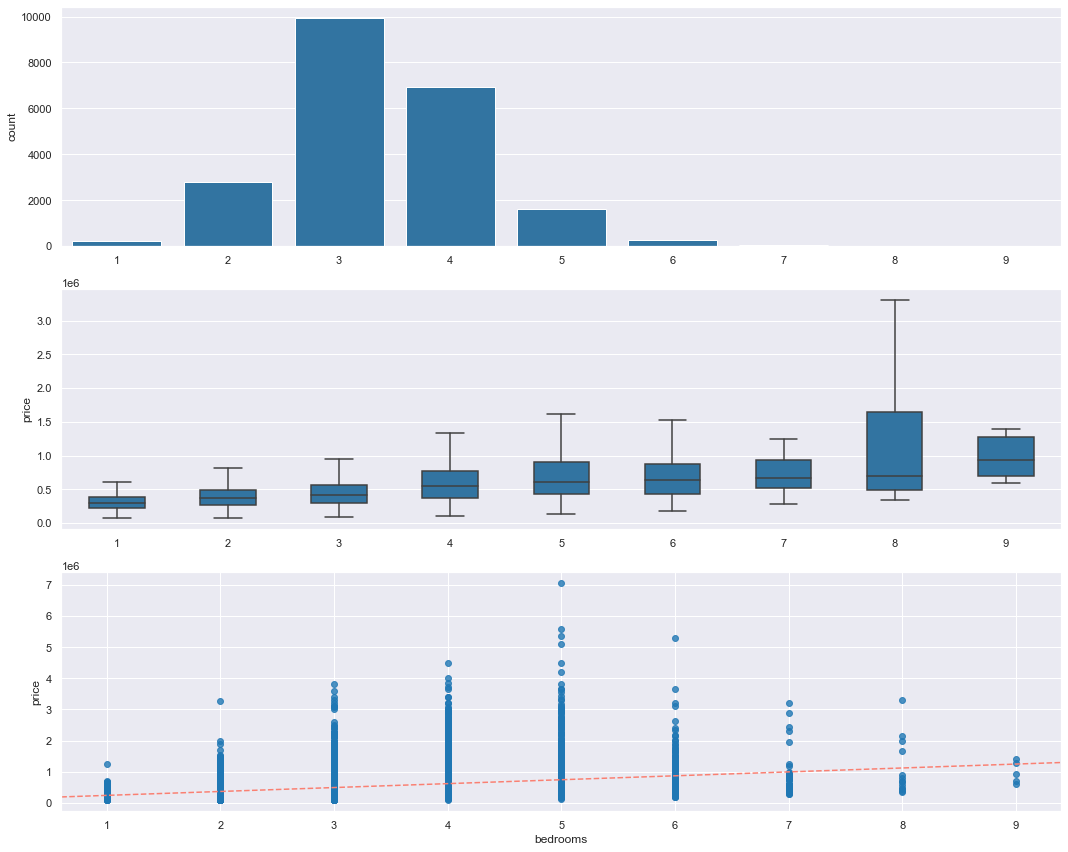

In [195]:
data.plot_predictor("bedrooms")

In [196]:
data.corr_with_target("bedrooms")

0.31481740602481456

### __*`floors`*__

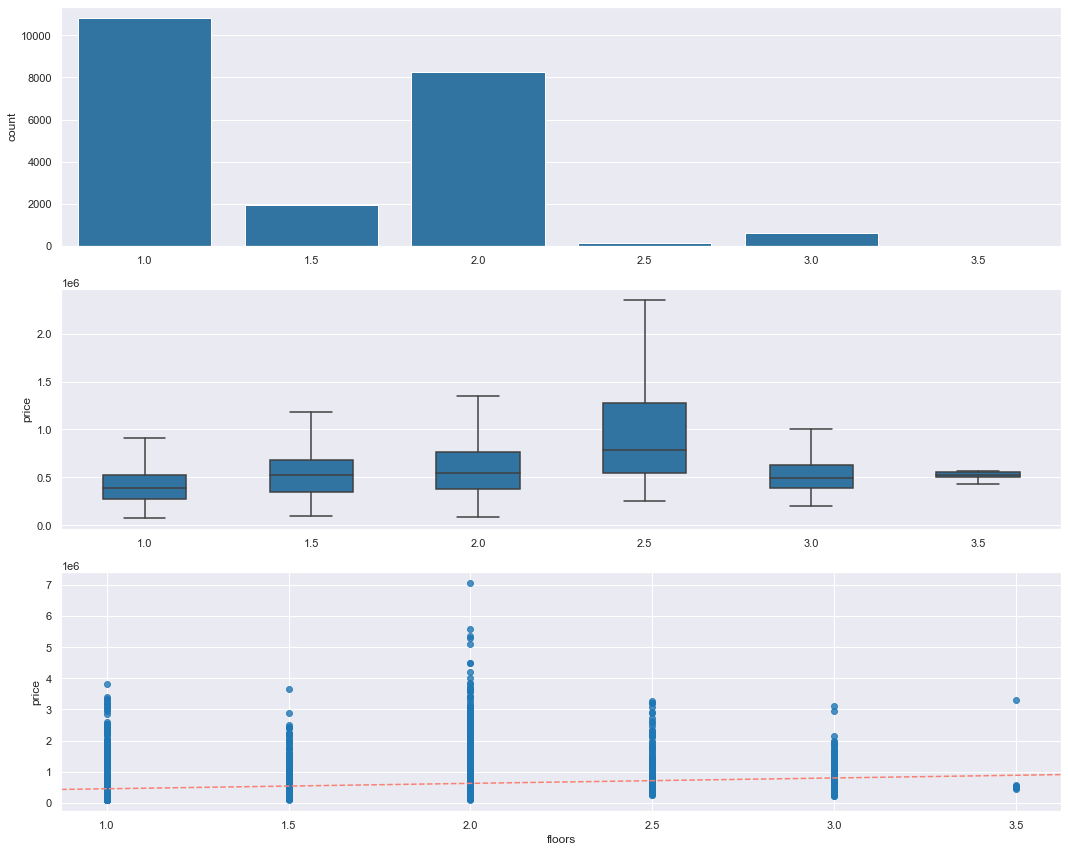

In [197]:
data.plot_predictor("floors")


In [198]:
data.corr_with_target("floors")

0.2604726443962779

##### _Feature Engineering:_ Converting `floors` to a Categorical Variable (`is_multi_storied`)

In [199]:
import math
is_multi_storied = data.df["floors"].map(lambda x: math.ceil(x) > 1).astype("uint64")
data.add_feature(is_multi_storied, name="is_multi_storied", var_type="categorical")

In [200]:
data.X_cat.head()

is_renovated  has_basement  is_multi_storied  is_waterfront
id                                                                     
7129300520             0             0                 0              1
6414100192             1             1                 1              0
5631500400             0             0                 0              0
2487200875             0             1                 0              0
1954400510             0             0                 0              0

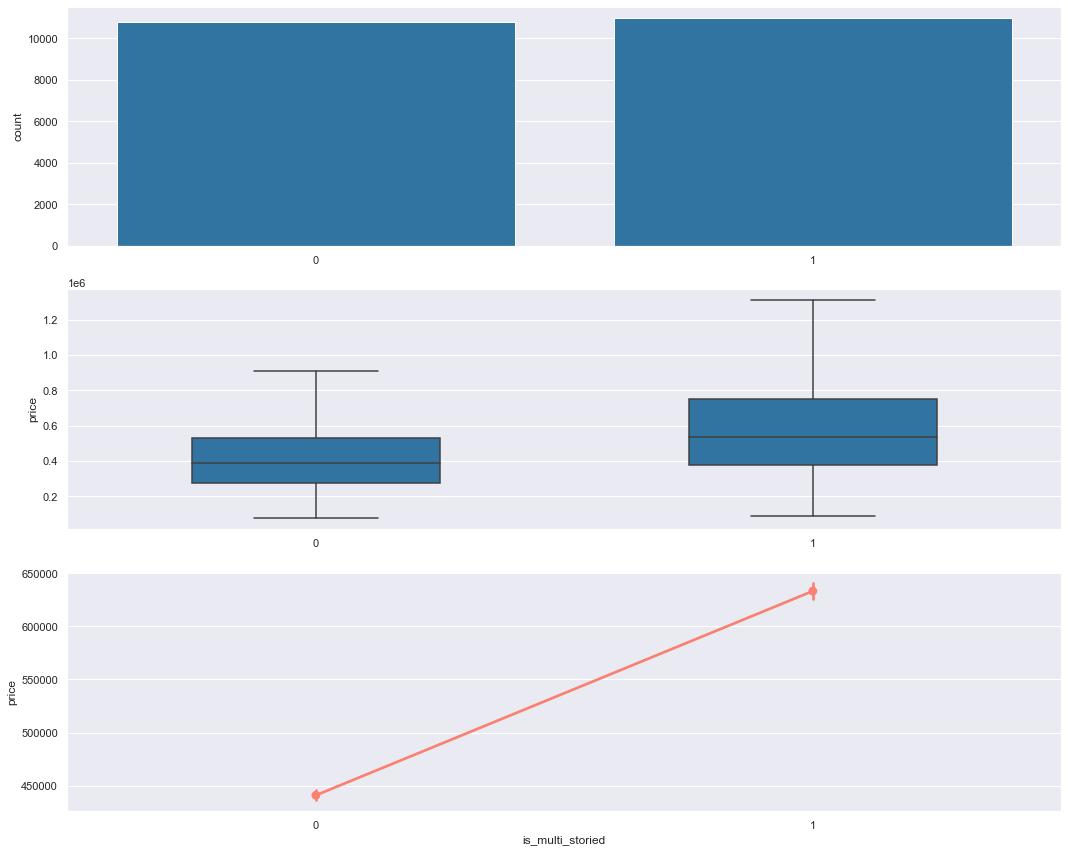

In [201]:
data.plot_predictor("is_multi_storied")

### __*`is_waterfront`*__

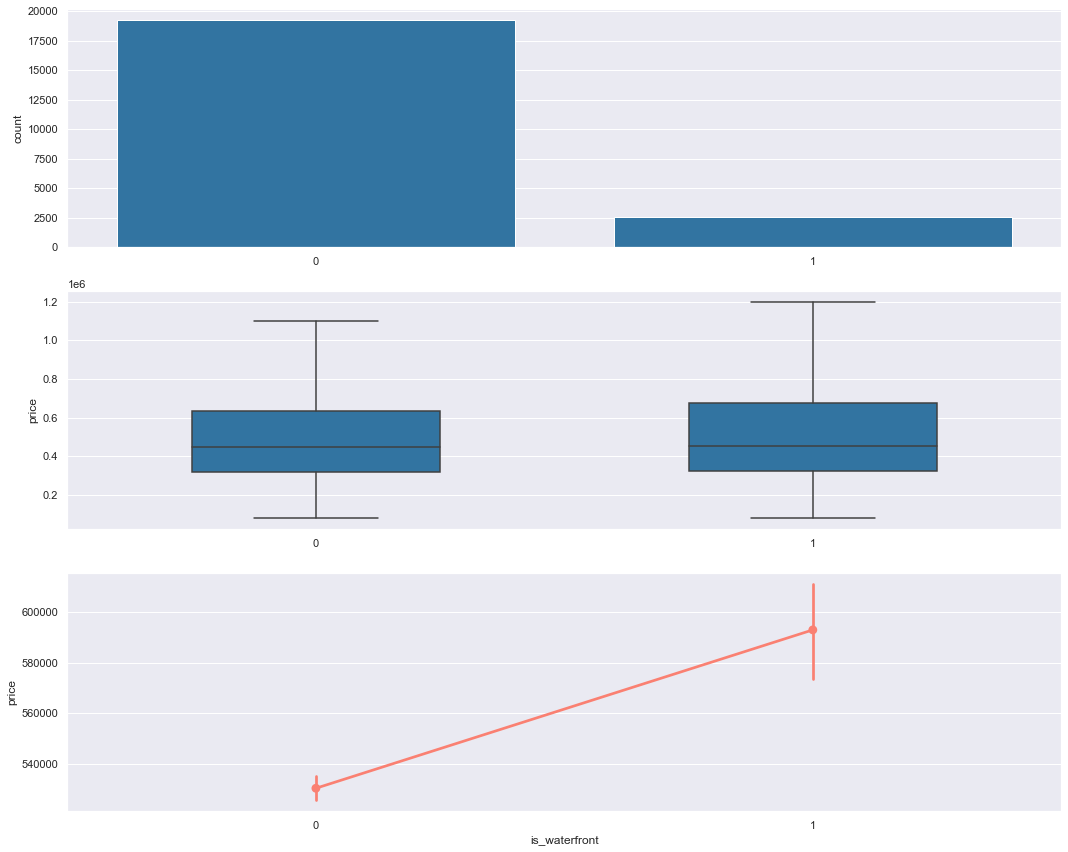

In [202]:
data.plot_predictor("is_waterfront")

# D. *Modeling*

In [203]:
data.start_traintest()

## D.1 - Parameter Selection

 The following base model was constructed:

 > **`price ~ log_sqft_living + log_sqft_living15`**

 However, the residuals from this model were non-normal and heteroskedastic. The target variable was log-transformed in order to remedy this, which greatly improved the normality and homoskedacity of the residuals, along with the $R^2$. Thus, the base model became:

> **`log_price ~ log_sqft_living + log_sqft_living15`**

Predictors were added to this model in a step-wise fashion. Every single predictor added was stastically significant. Due to the large number of observations in the dataset, no penalties were seen in $R^2_\text{adjusted}$.

Upon completing parameter selection, the model was improved to:

> **`log_price ~ log_sqft_living + log_sqft_living15 + grade + has_basement + is_renovated + is_multi_storied + condition`**

The `grade`, `has_basement`, `is_renovated`, `is_multi_storied`, and  `condition` predictors were deemed suitable as parameters to the linear model because their coefficients were significant and they improved $R^2_\text{adjusted}$ by an appreciable degree.

The 'Is_waterfront` predictor was discarded because its ceoefficient was very small relative to the others, and its effect on $R^2_\text{adjusted}$ was negligible.

The main issues during parameter selection were the `bathrooms` and `bedrooms` variables. These predictors were crucial with respect to the business problem, but they both had a slightly negative coefficient, indicating that adding a bathroom/bedroom decreases the value of a home. This was unacceptable. A solution to this problem was found by searching for interactions involving these predictors.


###
> ### **`price ~ log_sqft_living + log_sqft_living15`**

In [204]:
parameters = {"log_sqft_living", "log_sqft_living15"}

In [205]:
model = ols_regression(data, parameters)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     7774.
Date:                Wed, 08 Sep 2021   Prob (F-statistic):               0.00
Time:                        22:06:10   Log-Likelihood:            -3.2216e+05
No. Observations:               23103   AIC:                         6.443e+05
Df Residuals:                   23100   BIC:                         6.444e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          5.359e+05   1812.015    295.768      0.000    5.32e+05    5.39e+05
log_sqft_living    1.624e+05   2708.329     59.971      0.000    1.57e+05    1.68e+05
log_sqft_living15  7.686e+04   2710.812     28.354      0.000    7.15e+04    8.22e+04
==============================================================================
Omnibus:                    18598.890   Durbin-Watson:                   0.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           989448.442
Skew:                           3.482   Prob(JB):                         0.00
Kurtosis:                      34.295   Cond. No.                         2.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

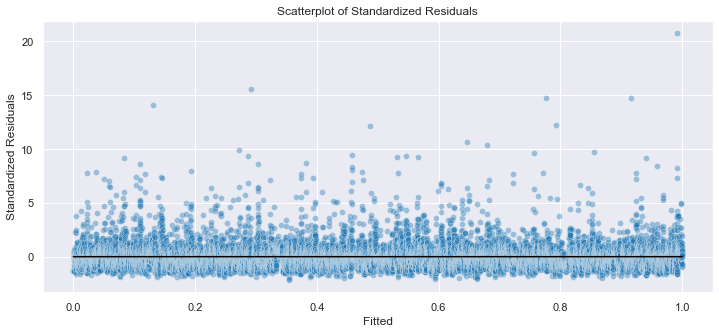

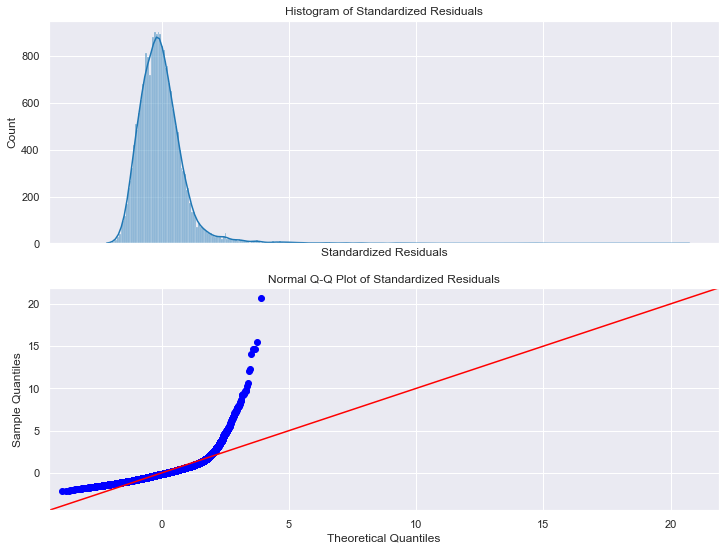

In [206]:
plot_residuals(model)

In [207]:
data.validate(parameters)

MSE           MAE           RMSE
train         6.096212e+10  161417.43051  246905.081160
test          6.363416e+10  162623.63176  252258.115361
|difference|  2.672038e+09    1206.20125    5353.034201

### 
> ### **`log_price ~ log_sqft_living + log_sqft_living15`** 

In [208]:
data.log_transform("price")

In [209]:
model = ols_regression(data, parameters)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                 1.083e+04
Date:                Wed, 08 Sep 2021   Prob (F-statistic):               0.00
Time:                        22:06:12   Log-Likelihood:                -10564.
No. Observations:               23103   AIC:                         2.113e+04
Df Residuals:                   23100   BIC:                         2.116e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            13.0373      0.003   5182.318      0.000      13.032      13.042
log_sqft_living       0.2626      0.004     69.835      0.000       0.255       0.270
log_sqft_living15     0.1299      0.004     34.514      0.000       0.123       0.137
==============================================================================
Omnibus:                      178.285   Durbin-Watson:                   0.705
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              144.240
Skew:                           0.122   Prob(JB):                     4.77e-32
Kurtosis:                       2.699   Cond. No.                         2.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [210]:
plot_residuals(model)

In [211]:
data.validate(parameters)

MSE       MAE      RMSE
train         0.113152  0.267656  0.336381
test          0.111707  0.268541  0.334226
|difference|  0.001445  0.000885  0.002155

### 
> ### __`log_price ~ log_sqft_living + log_sqft_living15 + grade`__

In [212]:
parameters.add("grade")

In [213]:
model = ols_regression(data, parameters)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     9593.
Date:                Wed, 08 Sep 2021   Prob (F-statistic):               0.00
Time:                        22:06:14   Log-Likelihood:                -8859.0
No. Observations:               23103   AIC:                         1.773e+04
Df Residuals:                   23099   BIC:                         1.776e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            13.0400      0.002   5579.340      0.000      13.035      13.045
log_sqft_living       0.1480      0.004     37.262      0.000       0.140       0.156
log_sqft_living15     0.0606      0.004     16.479      0.000       0.053       0.068
grade                 0.2218      0.004     60.620      0.000       0.215       0.229
==============================================================================
Omnibus:                      107.597   Durbin-Watson:                   0.726
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.909
Skew:                           0.139   Prob(JB):                     4.50e-23
Kurtosis:                       2.829   Cond. No.                         3.22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

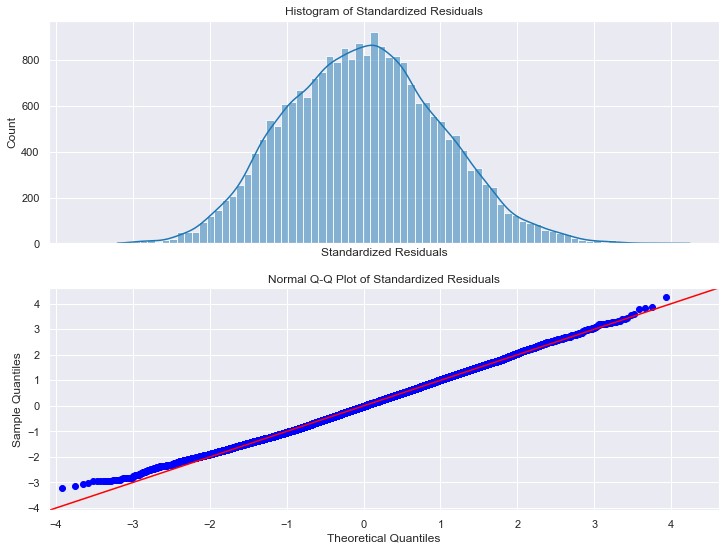

In [214]:
plot_residuals(model)

In [215]:
data.validate(parameters)

MSE       MAE      RMSE
train         0.113152  0.267656  0.336381
test          0.111707  0.268541  0.334226
|difference|  0.001445  0.000885  0.002155

###
> ### __`log_price ~ log_sqft_living + log_sqft_living15 + grade + bathrooms`__

In [216]:
parameters.add("bathrooms")

In [217]:
model = ols_regression(data, parameters)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     7197.
Date:                Wed, 08 Sep 2021   Prob (F-statistic):               0.00
Time:                        22:06:16   Log-Likelihood:                -8856.7
No. Observations:               23103   AIC:                         1.772e+04
Df Residuals:                   23098   BIC:                         1.776e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            13.0400      0.002   5579.683      0.000      13.035      13.045
log_sqft_living       0.1530      0.005     33.212      0.000       0.144       0.162
bathrooms            -0.0080      0.004     -2.145      0.032      -0.015      -0.001
log_sqft_living15     0.0602      0.004     16.330      0.000       0.053       0.067
grade                 0.2237      0.004     59.446      0.000       0.216       0.231
==============================================================================
Omnibus:                      104.098   Durbin-Watson:                   0.728
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.756
Skew:                           0.138   Prob(JB):                     2.18e-22
Kurtosis:                       2.833   Cond. No.                         4.13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

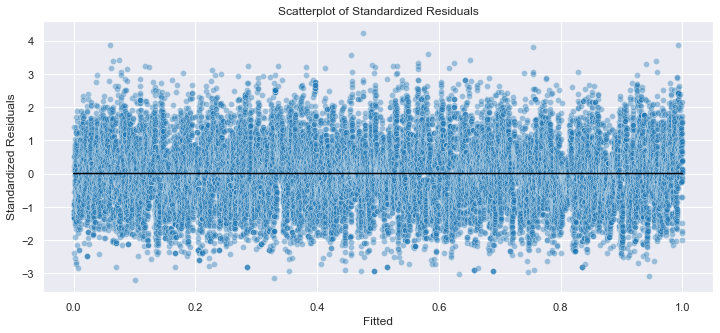

In [218]:
plot_residuals(model)

In [219]:
data.validate(parameters)

MSE       MAE      RMSE
train         0.113152  0.267656  0.336381
test          0.111707  0.268541  0.334226
|difference|  0.001445  0.000885  0.002155

In [220]:
parameters.remove("bathrooms")

###
> ### __`log_price ~ log_sqft_living + log_sqft_living15 + grade + has_basement`__

In [221]:
parameters.add("has_basement")

In [222]:
model = ols_regression(data, parameters)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     7611.
Date:                Wed, 08 Sep 2021   Prob (F-statistic):               0.00
Time:                        22:06:17   Log-Likelihood:                -8493.5
No. Observations:               23103   AIC:                         1.700e+04
Df Residuals:                   23098   BIC:                         1.704e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            13.0398      0.002   5668.096      0.000      13.035      13.044
log_sqft_living15     0.0721      0.004     19.791      0.000       0.065       0.079
grade                 0.2358      0.004     64.820      0.000       0.229       0.243
log_sqft_living       0.1130      0.004     27.464      0.000       0.105       0.121
has_basement          0.0661      0.002     27.251      0.000       0.061       0.071
==============================================================================
Omnibus:                       68.447   Durbin-Watson:                   0.786
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.954
Skew:                           0.132   Prob(JB):                     1.06e-15
Kurtosis:                       2.955   Cond. No.                         3.43
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

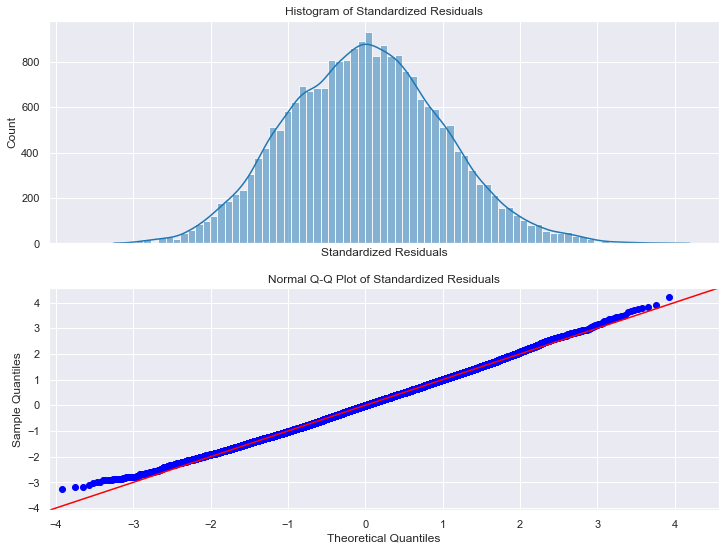

In [223]:
plot_residuals(model)

In [224]:
data.validate(parameters)

MSE       MAE      RMSE
train         0.113152  0.267656  0.336381
test          0.111707  0.268541  0.334226
|difference|  0.001445  0.000885  0.002155

###
> ### __`log_price ~ log_sqft_living + log_sqft_living15 + grade + has_basement + is_waterfront`__

In [225]:
parameters.add("is_waterfront")

In [226]:
model = ols_regression(data, parameters)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     6096.
Date:                Wed, 08 Sep 2021   Prob (F-statistic):               0.00
Time:                        22:06:19   Log-Likelihood:                -8485.5
No. Observations:               23103   AIC:                         1.698e+04
Df Residuals:                   23097   BIC:                         1.703e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            13.0397      0.002   5669.318      0.000      13.035      13.044
log_sqft_living15     0.0720      0.004     19.757      0.000       0.065       0.079
grade                 0.2360      0.004     64.886      0.000       0.229       0.243
log_sqft_living       0.1129      0.004     27.451      0.000       0.105       0.121
is_waterfront         0.0090      0.002      3.993      0.000       0.005       0.013
has_basement          0.0660      0.002     27.205      0.000       0.061       0.071
==============================================================================
Omnibus:                       65.540   Durbin-Watson:                   0.786
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.872
Skew:                           0.127   Prob(JB):                     4.97e-15
Kurtosis:                       2.940   Cond. No.                         3.43
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

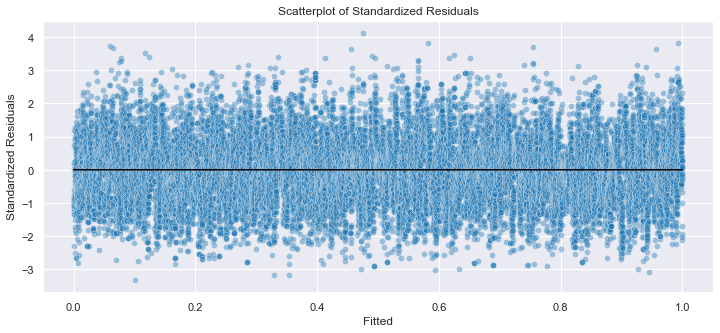

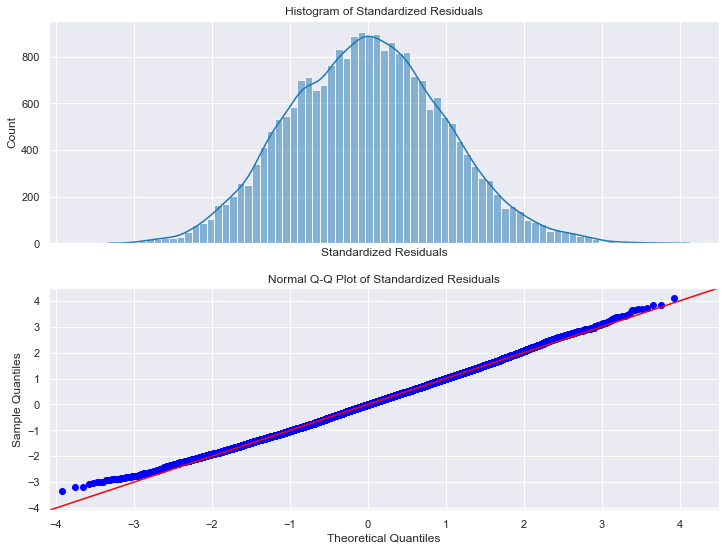

In [227]:
plot_residuals(model)

In [228]:
data.validate(parameters)

MSE       MAE      RMSE
train         0.113152  0.267656  0.336381
test          0.111707  0.268541  0.334226
|difference|  0.001445  0.000885  0.002155

###
> ### __`log_price ~ log_sqft_living + log_sqft_living15 + grade + has_basement + is_renovated`__

In [229]:
parameters.remove("is_waterfront")
parameters.add("is_renovated")

In [230]:
model = ols_regression(data, parameters)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     6245.
Date:                Wed, 08 Sep 2021   Prob (F-statistic):               0.00
Time:                        22:06:21   Log-Likelihood:                -8326.0
No. Observations:               23103   AIC:                         1.666e+04
Df Residuals:                   23097   BIC:                         1.671e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            13.0399      0.002   5709.237      0.000      13.035      13.044
is_renovated          0.0423      0.002     18.367      0.000       0.038       0.047
log_sqft_living15     0.0752      0.004     20.748      0.000       0.068       0.082
grade                 0.2367      0.004     65.537      0.000       0.230       0.244
log_sqft_living       0.1084      0.004     26.476      0.000       0.100       0.116
has_basement          0.0650      0.002     26.971      0.000       0.060       0.070
==============================================================================
Omnibus:                       59.647   Durbin-Watson:                   0.805
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.040
Skew:                           0.123   Prob(JB):                     9.17e-14
Kurtosis:                       2.959   Cond. No.                         3.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

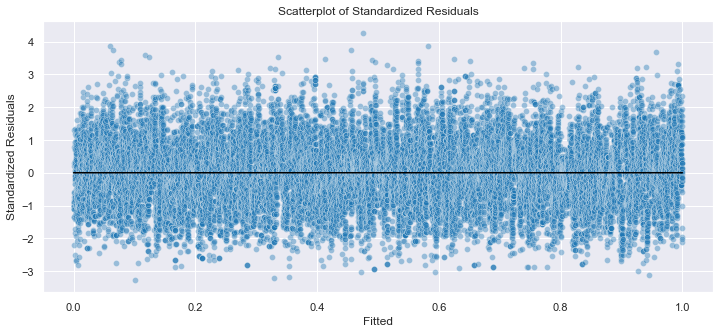

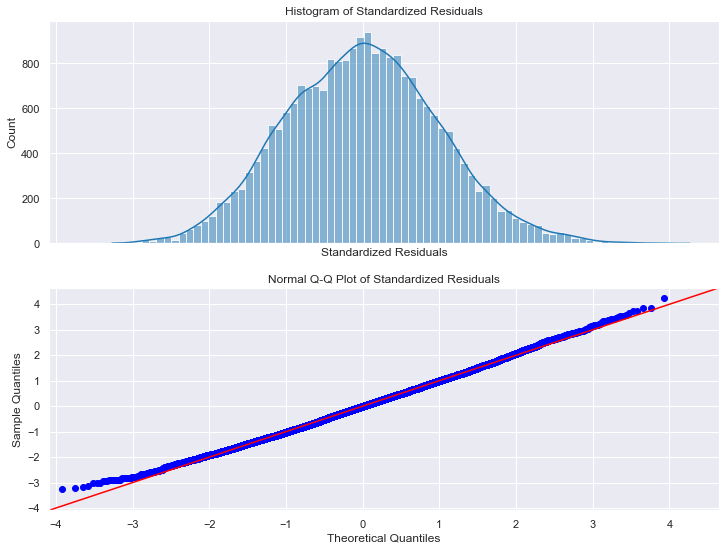

In [231]:
plot_residuals(model)

In [232]:
data.validate(parameters)

MSE       MAE      RMSE
train         0.113152  0.267656  0.336381
test          0.111707  0.268541  0.334226
|difference|  0.001445  0.000885  0.002155

###
> ### __`log_price ~ log_sqft_living + log_sqft_living15 + grade + has_basement + is_renovated + bedrooms`__

In [233]:
parameters.add("bedrooms")

In [234]:
model = ols_regression(data, parameters)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     5229.
Date:                Wed, 08 Sep 2021   Prob (F-statistic):               0.00
Time:                        22:06:23   Log-Likelihood:                -8293.5
No. Observations:               23103   AIC:                         1.660e+04
Df Residuals:                   23096   BIC:                         1.666e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            13.0400      0.002   5716.999      0.000      13.036      13.045
is_renovated          0.0418      0.002     18.168      0.000       0.037       0.046
bedrooms             -0.0241      0.003     -8.067      0.000      -0.030      -0.018
log_sqft_living15     0.0733      0.004     20.213      0.000       0.066       0.080
grade                 0.2308      0.004     62.678      0.000       0.224       0.238
log_sqft_living       0.1298      0.005     26.632      0.000       0.120       0.139
has_basement          0.0644      0.002     26.738      0.000       0.060       0.069
==============================================================================
Omnibus:                       61.981   Durbin-Watson:                   0.809
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.420
Skew:                           0.126   Prob(JB):                     2.79e-14
Kurtosis:                       2.962   Cond. No.                         4.33
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [235]:
plot_residuals(model)

In [236]:
data.validate(parameters)

MSE       MAE      RMSE
train         0.113152  0.267656  0.336381
test          0.111707  0.268541  0.334226
|difference|  0.001445  0.000885  0.002155

In [237]:
parameters.remove("bedrooms")

###
> ### __`log_price ~ log_sqft_living + log_sqft_living15 + grade + has_basement + is_renovated + is_multi_storied`__

In [238]:
parameters.add("is_multi_storied")

In [239]:
model = ols_regression(data, parameters)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     5256.
Date:                Wed, 08 Sep 2021   Prob (F-statistic):               0.00
Time:                        22:06:24   Log-Likelihood:                -8260.1
No. Observations:               23103   AIC:                         1.653e+04
Df Residuals:                   23096   BIC:                         1.659e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            13.0401      0.002   5725.340      0.000      13.036      13.045
is_renovated          0.0417      0.002     18.173      0.000       0.037       0.046
log_sqft_living15     0.0801      0.004     22.022      0.000       0.073       0.087
is_multi_storied      0.0316      0.003     11.497      0.000       0.026       0.037
grade                 0.2291      0.004     62.541      0.000       0.222       0.236
log_sqft_living       0.0951      0.004     22.435      0.000       0.087       0.103
has_basement          0.0761      0.003     29.383      0.000       0.071       0.081
==============================================================================
Omnibus:                       70.190   Durbin-Watson:                   0.815
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.784
Skew:                           0.135   Prob(JB):                     4.26e-16
Kurtosis:                       2.968   Cond. No.                         3.71
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

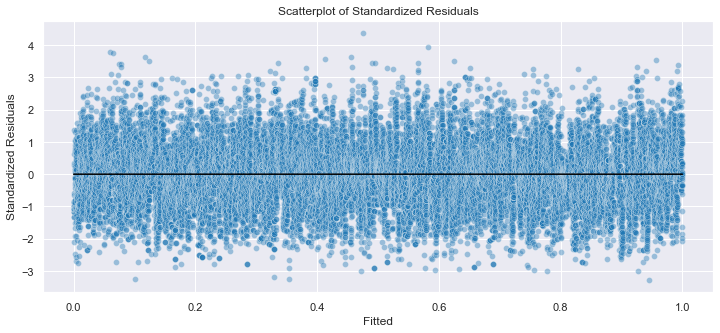

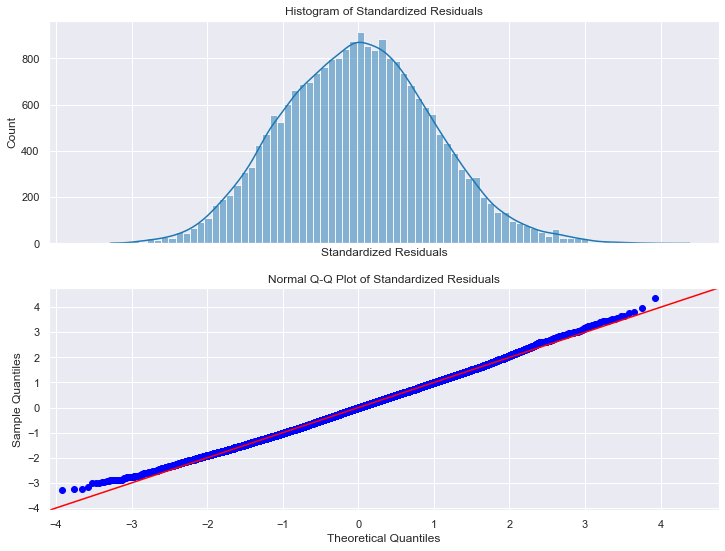

In [240]:
plot_residuals(model)

In [241]:
data.validate(parameters)

MSE       MAE      RMSE
train         0.113152  0.267656  0.336381
test          0.111707  0.268541  0.334226
|difference|  0.001445  0.000885  0.002155

###
> ### __`log_price ~ log_sqft_living + log_sqft_living15 + grade + has_basement + is_renovated + is_multi_storied + condition`__

In [242]:
parameters.add("condition")

In [243]:
model = ols_regression(data, parameters)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     4792.
Date:                Wed, 08 Sep 2021   Prob (F-statistic):               0.00
Time:                        22:06:26   Log-Likelihood:                -7842.9
No. Observations:               23103   AIC:                         1.570e+04
Df Residuals:                   23095   BIC:                         1.577e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            13.0411      0.002   5829.312      0.000      13.037      13.045
is_renovated          0.0455      0.002     20.148      0.000       0.041       0.050
log_sqft_living15     0.0839      0.004     23.467      0.000       0.077       0.091
is_multi_storied      0.0434      0.003     15.928      0.000       0.038       0.049
grade                 0.2382      0.004     65.967      0.000       0.231       0.245
condition             0.0668      0.002     29.141      0.000       0.062       0.071
log_sqft_living       0.0833      0.004     19.916      0.000       0.075       0.092
has_basement          0.0723      0.003     28.397      0.000       0.067       0.077
==============================================================================
Omnibus:                       72.992   Durbin-Watson:                   0.820
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.675
Skew:                           0.135   Prob(JB):                     1.00e-16
Kurtosis:                       3.059   Cond. No.                         3.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

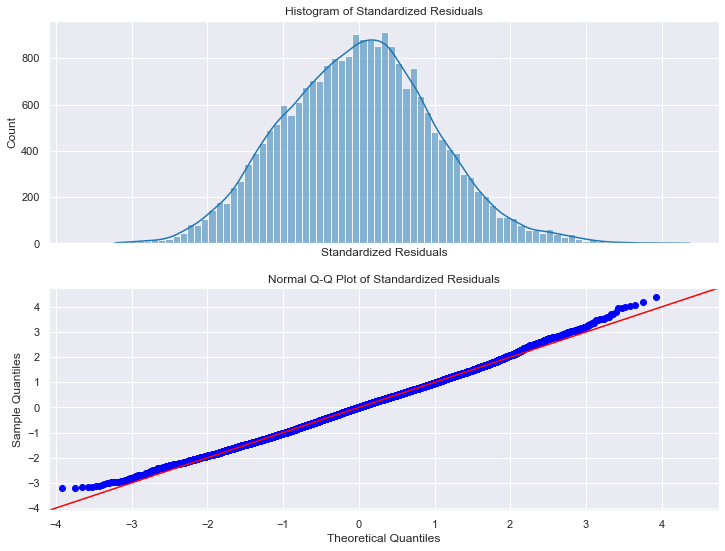

In [244]:
plot_residuals(model)

In [245]:
data.validate(parameters)

MSE       MAE      RMSE
train         0.113152  0.267656  0.336381
test          0.111707  0.268541  0.334226
|difference|  0.001445  0.000885  0.002155

In [246]:
data.end_traintest()

## D.2 - Searching for Interactions

The number of bedrooms and bathrooms in a home is related to its square footage, and so `price` was plotted against `log_sqft_living` for each possible value of `bathrooms` and `bedrooms`.

It can be clearly seen that a home's *price per square foot* interacts strongly with the number of bathrooms and bedrooms. Therefore, both of these interaction terms were applied to the model to allow for a more meaningful and realistic interpretation of the `bathrooms` and `bedrooms` variables.

####
> ### __`log_price ~ log_sqft_living | bathrooms`__

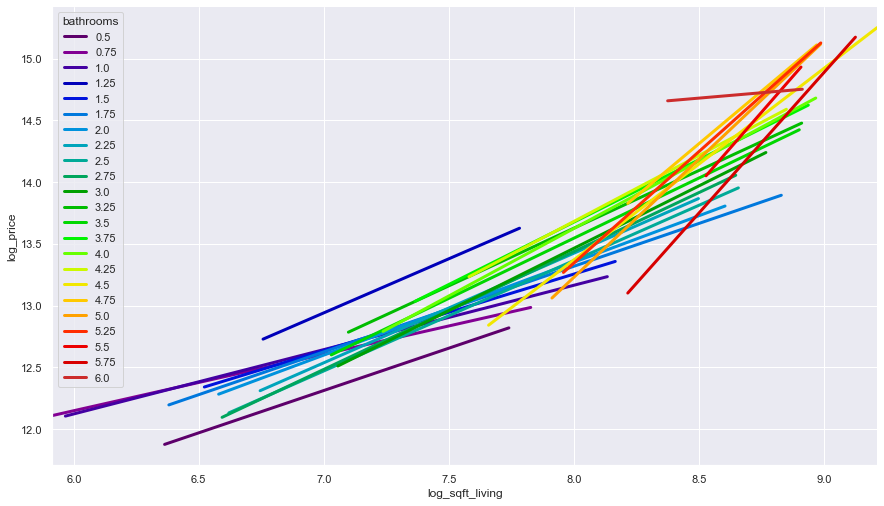

In [247]:
sqft_living_by_bathrooms_df = data.df[[data.target, "log_sqft_living", "bathrooms"]]
sns.lmplot(x="log_sqft_living", y=data.target, data=sqft_living_by_bathrooms_df, fit_reg=True, scatter=False, x_jitter=0.025, hue="bathrooms", height=7, aspect=1.75, ci=None, legend_out=False, palette="nipy_spectral", scatter_kws={"alpha": 0.1}, line_kws={"linewidth": 3})

In [248]:
sqft_living_by_bathrooms = data.df["log_sqft_living"] * data.df["bathrooms"]
data.add_feature(sqft_living_by_bathrooms, name="log_sqft_living_by_bathrooms", var_type="continuous")

####
> ### __`log_price ~ log_sqft_living | bedrooms`__

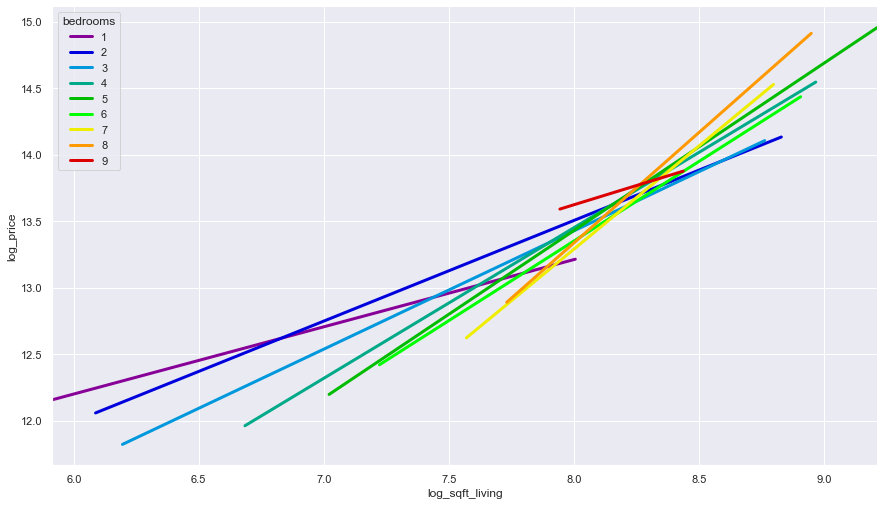

In [249]:
sqft_living_by_bedrooms_df = data.df[[data.target, "log_sqft_living", "bedrooms"]]
sns.lmplot(x="log_sqft_living", y=data.target, data=sqft_living_by_bedrooms_df, fit_reg=True, scatter=False, x_jitter=0.025, hue="bedrooms", height=7, aspect=1.75, ci=None, legend_out=False, palette="nipy_spectral", scatter_kws={"alpha": 0.1}, line_kws={"linewidth": 3})

In [250]:
sqft_living_by_bedrooms = data.df["log_sqft_living"] * data.df["bedrooms"]
data.add_feature(sqft_living_by_bedrooms, name="log_sqft_living_by_bedrooms", var_type="continuous")

## D.3 - Modeling with the Interaction Terms

In [251]:
data.start_traintest()

###
> ### __`log_price ~ log_sqft_living + log_sqft_living15 + grade + has_basement + is_renovated + is_multi_storied + condition + bathrooms + bedrooms + {log_sqft_living | bathrooms}`__

In [252]:
parameters.add("bathrooms")
parameters.add("bedrooms")
parameters.add("log_sqft_living_by_bathrooms")

In [253]:
model = ols_regression(data, parameters)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     3539.
Date:                Wed, 08 Sep 2021   Prob (F-statistic):               0.00
Time:                        22:06:29   Log-Likelihood:                -7470.3
No. Observations:               23103   AIC:                         1.496e+04
Df Residuals:                   23092   BIC:                         1.505e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       13.0407      0.002   5922.966      0.000      13.036      13.045
is_renovated                     0.0432      0.002     19.398      0.000       0.039       0.048
bedrooms                        -0.0270      0.003     -9.273      0.000      -0.033      -0.021
log_sqft_living15                0.0796      0.004     22.584      0.000       0.073       0.087
is_multi_storied                 0.0559      0.003     19.951      0.000       0.050       0.061
grade                            0.2179      0.004     58.083      0.000       0.211       0.225
condition                        0.0683      0.002     30.187      0.000       0.064       0.073
log_sqft_living                 -0.0004      0.007     -0.066      0.948      -0.014       0.013
bathrooms                       -0.8572      0.033    -25.889      0.000      -0.922      -0.792
has_basement                     0.0792      0.003     31.236      0.000       0.074       0.084
log_sqft_living_by_bathrooms     0.9460      0.037     25.779      0.000       0.874       1.018
==============================================================================
Omnibus:                       18.949   Durbin-Watson:                   0.840
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.986
Skew:                           0.067   Prob(JB):                     7.54e-05
Kurtosis:                       3.043   Cond. No.                         48.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

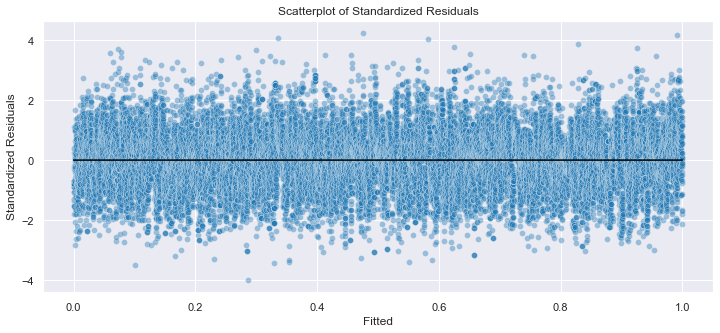

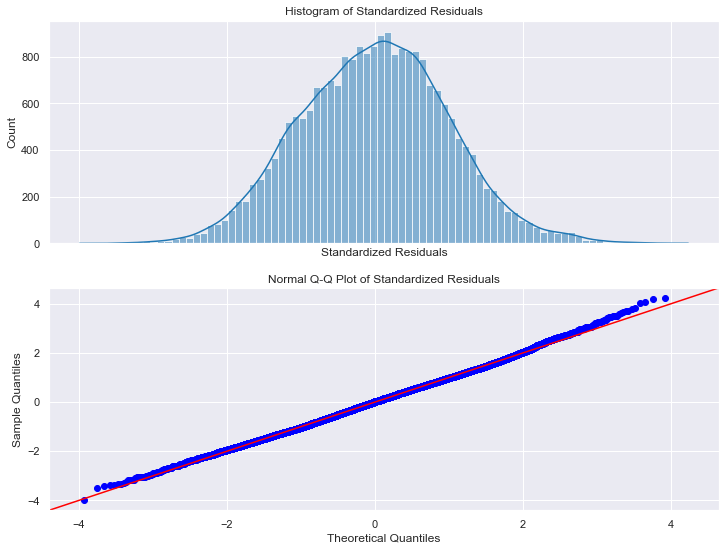

In [254]:
plot_residuals(model)

In [255]:
data.validate(parameters)

MSE       MAE      RMSE
train         0.109502  0.264247  0.330912
test          0.108582  0.265309  0.329519
|difference|  0.000920  0.001061  0.001393

###
> ### __`log_price ~ log_sqft_living + log_sqft_living15 + grade + has_basement + is_renovated + is_multi_storied + condition + bathrooms + bedrooms + {log_sqft_living | bedrooms}`__

In [256]:
parameters.remove("log_sqft_living_by_bathrooms")
parameters.add("log_sqft_living_by_bedrooms")


In [257]:
model = ols_regression(data, parameters)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     3511.
Date:                Wed, 08 Sep 2021   Prob (F-statistic):               0.00
Time:                        22:06:30   Log-Likelihood:                -7526.8
No. Observations:               23103   AIC:                         1.508e+04
Df Residuals:                   23092   BIC:                         1.516e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      13.0412      0.002   5908.945      0.000      13.037      13.046
is_renovated                    0.0433      0.002     19.409      0.000       0.039       0.048
bedrooms                       -0.8521      0.035    -24.074      0.000      -0.921      -0.783
log_sqft_living15               0.0759      0.004     21.412      0.000       0.069       0.083
is_multi_storied                0.0495      0.003     17.799      0.000       0.044       0.055
grade                           0.2263      0.004     60.754      0.000       0.219       0.234
condition                       0.0683      0.002     30.109      0.000       0.064       0.073
log_sqft_living                -0.0330      0.008     -4.119      0.000      -0.049      -0.017
bathrooms                      -0.0204      0.004     -5.525      0.000      -0.028      -0.013
log_sqft_living_by_bedrooms     0.9393      0.040     23.420      0.000       0.861       1.018
has_basement                    0.0738      0.003     29.208      0.000       0.069       0.079
==============================================================================
Omnibus:                       38.172   Durbin-Watson:                   0.846
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.583
Skew:                           0.092   Prob(JB):                     4.19e-09
Kurtosis:                       3.077   Cond. No.                         51.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

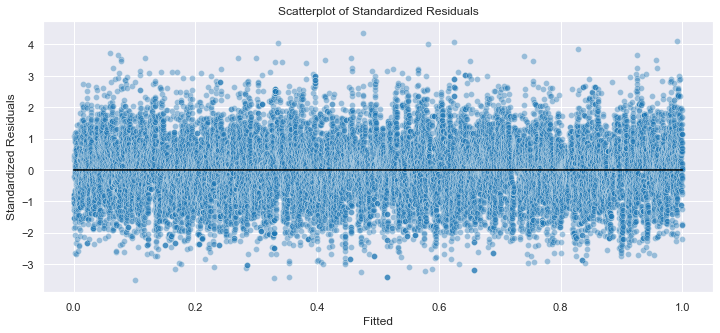

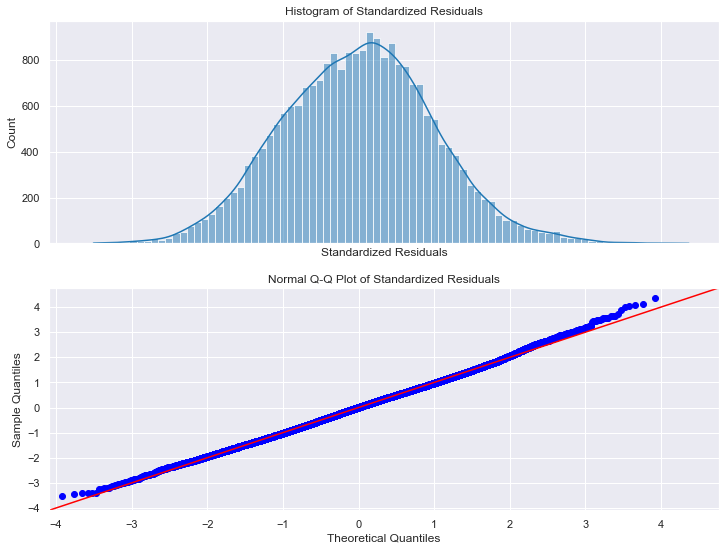

In [258]:
plot_residuals(model)

In [259]:
data.validate(parameters)

MSE       MAE      RMSE
train         0.109502  0.264247  0.330912
test          0.108582  0.265309  0.329519
|difference|  0.000920  0.001061  0.001393

###
> ### __`log_price ~ log_sqft_living + log_sqft_living15 + grade + has_basement + is_renovated + is_multi_storied + condition + bathrooms + bedrooms + {log_sqft_living | bathrooms} + {log_sqft_living | bedrooms}`__

In [260]:
parameters.add("log_sqft_living_by_bathrooms")

In [261]:
model = ols_regression(data, parameters)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     3236.
Date:                Wed, 08 Sep 2021   Prob (F-statistic):               0.00
Time:                        22:06:32   Log-Likelihood:                -7430.0
No. Observations:               23103   AIC:                         1.488e+04
Df Residuals:                   23091   BIC:                         1.498e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       13.0408      0.002   5933.098      0.000      13.037      13.045
is_renovated                     0.0428      0.002     19.287      0.000       0.038       0.047
bedrooms                        -0.4396      0.046     -9.553      0.000      -0.530      -0.349
log_sqft_living15                0.0773      0.004     21.909      0.000       0.070       0.084
is_multi_storied                 0.0549      0.003     19.610      0.000       0.049       0.060
grade                            0.2189      0.004     58.420      0.000       0.212       0.226
condition                        0.0686      0.002     30.351      0.000       0.064       0.073
log_sqft_living                 -0.0397      0.008     -4.967      0.000      -0.055      -0.024
bathrooms                       -0.6140      0.043    -14.371      0.000      -0.698      -0.530
log_sqft_living_by_bedrooms      0.4694      0.052      8.984      0.000       0.367       0.572
has_basement                     0.0779      0.003     30.748      0.000       0.073       0.083
log_sqft_living_by_bathrooms     0.6683      0.048     13.945      0.000       0.574       0.762
==============================================================================
Omnibus:                       20.260   Durbin-Watson:                   0.846
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.385
Skew:                           0.067   Prob(JB):                     3.75e-05
Kurtosis:                       3.059   Cond. No.                         89.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

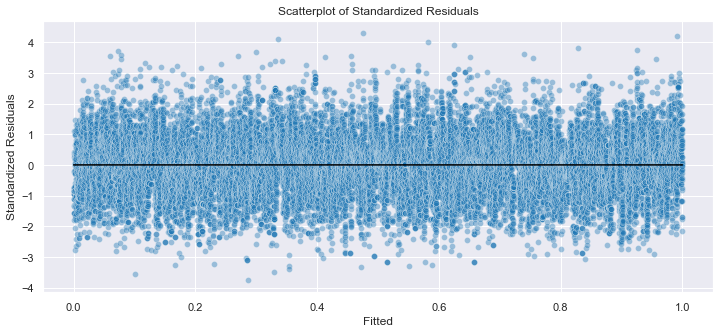

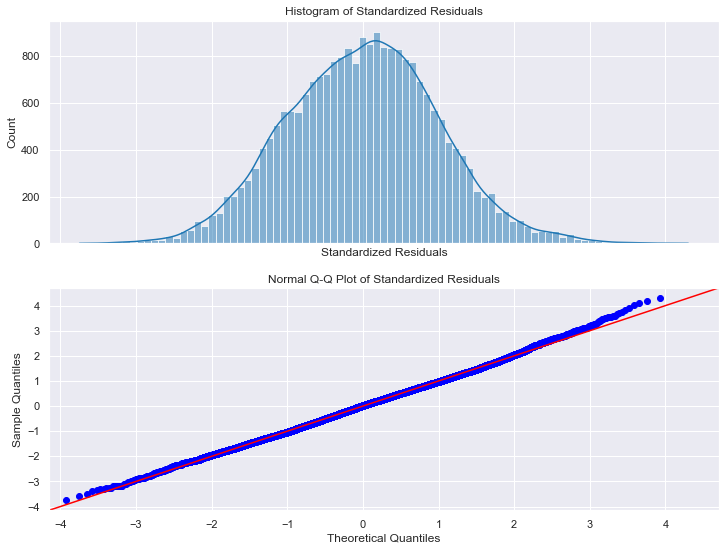

In [262]:
plot_residuals(model)

In [263]:
data.validate(parameters)

MSE       MAE      RMSE
train         0.109502  0.264247  0.330912
test          0.108582  0.265309  0.329519
|difference|  0.000920  0.001061  0.001393

In [264]:
data.end_traintest()

# E. *Evaluation*

## *Results*


The interaction terms were modeled individually and together. The model with both interaction terms was chosen as the final product. With an $R^2_\text{adjusted}$ of $0.606$, the model accounts for around $60\%$ of the variation in the dataset. The equation describing this model is shown below:

> **`log_price ~ log_sqft_living + log_sqft_living15 + grade + has_basement + is_renovated + is_multi_storied + condition + bathrooms + bedrooms + {log_sqft_living | bathrooms} + {log_sqft_living | bedrooms}`**

The model residuals show constant variance, and so this model adheres to the assumption of homoskedadicity. This is illustrated in the scatterplot of the residuals, shown below:

<center><img src="images/hist_residuals_final.png" width="700"></center>

The residuals are essentially normally distributed, with $skew = 0.067$ and $kurtosis = 3.059$, and so this model also adheres to the assumption of normality of the residuals. The normality of the residuals can be seen in the histogram and normal Q-Q plot of these residuals, shown below:

<center><img src="images/qq_plot_residuals_final.png" width="700"></center>

The validation results indicate that the model can effectively predict house prices in *King County*. A table summarizing these results is shown below:

<center><img src="images/model_validation_results.png" width="300"></center>


The model has a total of $11$ parameters. All of the parameters were statisticaly significant. A summary of these parameters is given in the table below:

<center><img src="images/model_parameters_final.PNG" width="500"></center>
<br>

> ##### $\beta_{\text{\{log-sqft-living\}}}$, $\beta_{\text{\{log-sqft-living | bathrooms\}}}$, & $\beta_{\text{\{log-sqft-living | bedrooms\}}}$

* $\beta_{\text{\{log-sqft-living\}}}$ describes the percentage increase in price per $1\%$ increase in square footage of the home *given there 0 bathrooms and 0 bedrooms*

* $\beta_{\text{\{log-sqft-living | bathrooms\}}}$ describes how $\beta_{\text{\{log-sqft-living\}}}$ changes with respect to the number of bathrooms in the home. In other words, if a single full bathroom were to be added to a home, the model will account for this by adding $[\dfrac{1}{s_\text{bathrooms}}] \times \beta_{\text{\{log-sqft-living | bathrooms\}}}$ to $\beta_{\text{\{log-sqft-living\}}}$

* $\beta_{\text{\{log-sqft-living | bedrooms\}}}$ describes how $\beta_{\text{\{log-sqft-living\}}}$ changes with respect to the number of bedrooms in the home. In other words, if a single bedroom were to be added to a home, the model will account for this by adding $[\dfrac{1}{s_\text{bedrooms}}] \times \beta_{\text{\{log-sqft-living | bedrooms\}}}$ to $\beta_{\text{\{log-sqft-living\}}}$
[Note: $s_x$ = standard deviation of feature]

$\beta_{\text{\{log-sqft-living\}}} = -0.0397$ means that price decreases about $0.04\%$ for a $1\%$ increase in square footage of the living area. This relatively small, negative change is counter-intuitive. It arises from the fact that, as `log-sqft-living` increases, so will `bathrooms` and `bedrooms`, which means  $\beta_{\text{\{log-sqft-living\}}}$ is adjusted by $\beta_{\text{\{log-sqft-living | bathrooms\}}}$ or $\beta_{\text{\{log-sqft-living | bedrooms\}}}$ everytime the total number of rooms change. Thus, all of the variance that was explained by $\beta_{\text{\{log-sqft-living\}}}$ before the interaction terms were present is now being captured by $\beta_{\text{\{log-sqft-living | bathrooms\}}}$ and $\beta_{\text{\{log-sqft-living | bedrooms\}}}$. In fact, the value of $\beta_{\text{\{log-sqft-living\}}}$ by itself is no longer relevant because it is now valid only when there are no bathrooms and bedrooms (which is a theoretical situation).

$\beta_{\text{\{log-sqft-living | bathrooms\}}} = 0.6683$ means that $\beta_{\text{\{log-sqft-living\}}}$ increases by ${0.6683}$ for every unit increase in the number of bathrooms.
Likewise, $\beta_{\text{\{log-sqft-living | bedrooms\}}} = 0.4694$ means that $\beta_{\text{\{log-sqft-living\}}}$ increases by ${0.4694}$ for every unit increase in the number of bedrrooms.

> ##### $\beta_{\text{\{bathrooms\}}}$ & $\beta_{\text{\{bedrooms\}}}$

* $\beta_{\text{\{bathrooms\}}}$ describes the percentage increase in price for every unit bathroom added *given that the square footage of the home is 0*
* $\beta_{\text{\{bedrooms\}}}$ describes the percentage increase in price for every unit bedroom added *given that the square footage of the home is 0*

 Similar to what was explained above, this counter-intuitive result stems from the fact that most all the variance that was explained by $\beta_{\text{\{bathrooms\}}}$ and  $\beta_{\text{\{bedrooms\}}}$ before the interaction terms were present is now being captured by $\beta_{\text{\{log-sqft-living | bathrooms\}}}$ and $\beta_{\text{\{log-sqft-living | bedrooms\}}}$. These coefficients are no longer relevant because they are valid only when the square footage is $0$ (which is impossible).

> ##### $\beta_{\text{\{log-sqft-living15\}}}$, $\beta_{\text{\{grade\}}}$, $\beta_{\text{\{condition\}}}$, $\beta_{\text{\{is-multi-storied\}}}$, $\beta_{\text{\{is-renovated\}}}$, & $\beta_{\text{\{has-basement\}}}$

* $\beta_{\text{\{log-sqft-living15\}}} = 0.0773$ means that price increases by $0.0773\%$ per $1\%$ increase in the average home square footage of the 15 nearest neighbors

* $\beta_{\text{\{grade\}}} = 0.2189$ means that price increases by $[e^{\beta_{\text{\{grade\}}}} - 1] * 100\% = 24.47\%$ per unit increase in rating for the home's grade

* $\beta_{\text{\{condition\}}} = 0.0686$ means that price increases by $[e^{\beta_{\text{\{condition\}}}} - 1] * 100\% = 7.10\%$ per unit increase in rating for the home's condition

* $\beta_{\text{\{is-multi-storied\}}} = 0.0549$ means that the price increases by $[e^{\beta_{\text{\{is-multi-storied\}}}} - 1] * 100\% = 5.64\%$ when going from a single-story home to a home with two or more stories

* $\beta_{\text{\{is-renovated\}}} = 0.0428$ means that the price increases by $[e^{\beta_{\text{\{is-renovated\}}}} - 1] * 100\% = 4.38\%$ when going from a home that has never been renovated to one that has been renovated at least once

* $\beta_{\text{\{has-basement\}}} = 0.0779$ means that the price increases by $[e^{\beta_{\text{\{has-basement\}}}} - 1] * 100\% = 8.10\%$ when going from a home without a basement to one that does have a basement


## *Conclusion*


As for evaluating the price of homes in *King County*, the most important attributes are:
> * grade (quality of building construction and design)
> * square footage of the living area
> * number of bathrooms
> * number of bedrooms

With respect to the company building homes, all of the features described by the model can and should be used to estimate the selling price of a given home in *King County*.

When pricing their own custom homes, the square footage, number of bathrooms, and number of bedrooms will be the most important features since the model takes into account the interactions between these attributes. In total, the company will be able to use the following set of features when pricing their homes:

> * square footage of the living area
> * the average square footage of the nearest 15 neighbors to the lot where the home will be built
> * number of bathrooms
> * number of bedrooms
> * whether or not the home will have multiple stories
> * whether or not the home will have a basement
> * condition (assuming the newly built home to have a rating of 5/5)

## *Limitations & Ideas for Further Analysis*


The model explains about $%60$ of the variation of home prices in *King County*, and so needs further improvement. More analysis should be done on how location and seasonality affect prices. Also, the company should consider exploring features that are demographic in nature, instead of relying solely on real estate data, since we could be omitting important variables. For example, gathering census data on the average income per household.

As for grade, the company needs to investigates how exactly this rating is determined in *King County* due to its important as a predictor. Without an understanding of how this rating is assigned, it cannot be used to price custom homes, and the accuracy of the model will suffer greatly. Going further, since grade seems to be holistic, thorough research into this predictor would allow us to distill it out the more fundamental attibutes on which grade depends. These attributes would be much more suitable for use in a model, and would paint a clearer picture of the underlying factors that determine house prices in this county.